In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from xgboost import XGBRegressor
from tensorflow import keras
from scipy.interpolate import interpn
from tqdm import tqdm
import shap

In [3]:
from load_data import process_steel_data

full_path = 'data/'
path = 'data/MDC_Data_Descriptions_MeCoMeP-r-value.xlsx'
correlation_rate = 0.2
dvl_line = 1

df = process_steel_data(full_path, path, correlation_rate, dvl_line, model_output=True)
df = pd.get_dummies(df, columns=['steel_family'], prefix='steel').drop(['steel_grade'], axis=1)

Dropped 25 columns


/opt/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [4]:
from sklearn.preprocessing import StandardScaler

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Identify binary columns (one-hot encoded)
binary_columns = [col for col in df.columns if col.startswith('steel_')]

# Identify columns to scale (non-binary columns)
columns_to_scale = [col for col in df.columns if col not in binary_columns + ['steel_grade']]

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df[columns_to_scale])
test_scaled = scaler.transform(test_df[columns_to_scale])

train_scaled_df = pd.DataFrame(train_scaled, columns=columns_to_scale)
test_scaled_df = pd.DataFrame(test_scaled, columns=columns_to_scale)

for col in binary_columns:
    train_scaled_df[col] = train_df[col].values
    test_scaled_df[col] = test_df[col].values

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

def optimize_hyperparameters_rfr(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 150, 200, 350, 300],
    }
    grid_search = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_
    }

def train_optimized_model(df, model_type):

    X = df.drop(['r_value'] if 'steel_grade' in df.columns else ['r_value'], axis=1)
    y = df['r_value']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model based on type
    if model_type == 'rfr':
        optimization_results = optimize_hyperparameters_rfr(X_train, y_train)
    elif model_type == 'xgb':
        optimization_results = optimize_hyperparameters_xgb(X_train, y_train)
    elif model_type == 'gpr':
        optimization_results = optimize_hyperparameters_gpr(X_train, y_train)
    elif model_type == 'knn':
        optimization_results = optimize_hyperparameters_knn(X_train, y_train)
    elif model_type == 'svr':
        optimization_results = optimize_hyperparameters_svr(X_train, y_train)
    elif model_type == 'ridge':
        optimization_results = optimize_hyperparameters_ridge(X_train, y_train)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    # Get best model and make predictions
    best_model = optimization_results['best_estimator']
    best_model.fit(X_train, y_train)
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
      
    results = {
        'model': best_model,
        'best_params': optimization_results['best_params'],
        'best_score': optimization_results['best_score'],
        'train_mse': mean_squared_error(y_train, y_pred_train),
        'val_mse': mean_squared_error(y_test, y_pred_test),
        'train_mae': mean_absolute_error(y_train, y_pred_train),
        'val_mae': mean_absolute_error(y_test, y_pred_test),
        'train_r2': r2_score(y_train, y_pred_train),
        'val_r2': r2_score(y_test, y_pred_test)
    }
    
    return results

In [6]:
# Run optimization
model_info = train_optimized_model(train_scaled_df, model_type='rfr')

print(f"Best Parameters: {model_info['best_params']}")
print(f"Best CV Score (MSE): {model_info['best_score']}")
print(f"VAL MAE: {model_info['val_mae']}")
print(f"VAL R2: {model_info['val_r2']}")

Best Parameters: {'n_estimators': 300}
Best CV Score (MSE): 0.15270391356626653
VAL MAE: 0.1490218037143544
VAL R2: 0.9567903961691843


In [7]:
def tol90(y_true, y_pred):
    """Calculate the 90th percentile of absolute errors"""
    errors = np.abs(y_true - y_pred)
    return np.percentile(errors, 90)

def density_scatter(x, y, bins=30, **kwargs):
    """Create a density scatter plot"""
    x = np.asarray(x).flatten()
    y = np.asarray(y).flatten()
    data, x_e, y_e = np.histogram2d(x, y, bins=bins)
    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:] + y_e[:-1])),
                data.T/data.max(),
                np.vstack([x,y]).T,
                method="splinef2d",
                bounds_error=False)
    z[np.where(np.isnan(z))] = 0.0
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    plt.scatter(x, y, c=z, **kwargs)

def plot_predicted_vs_actual(model, df, features_dict=None, model_type=None, target_column='r_value', title=None, figsize=(10, 8)):
    """
    Plot predictions vs actual values for various model types
    
    Parameters:
    -----------
    model : object
        The trained model (sklearn, keras, pytorch, or dict containing model)
    df : pandas.DataFrame
        DataFrame containing features and target
    features_dict : dict, optional
        Dictionary of feature categories for PyTorch models
    model_type : str, optional
        Type of model ('pytorch_mlp', 'keras', or None for sklearn)
    target_column : str, default='tensile_strength'
        Name of the target column in df
    title : str, optional
        Plot title
    figsize : tuple, default=(10, 8)
        Figure size
    """
    plt.figure(figsize=figsize)
    
    # Get actual values
    actual = df[target_column].values
    
    # Get predictions based on model type
    if isinstance(model, keras.Model):
        X = df.drop([target_column], axis=1).values.astype('float32')
        predicted = model.predict(X).flatten()
    
    elif model_type == 'pytorch_mlp':
        # Prepare feature arrays for PyTorch MLP
        feature_arrays = {}
        for category in features_dict.keys():
            available_features = [col for col in features_dict[category] 
                                if col in df.columns]
            if available_features:
                scaler = StandardScaler()
                feature_arrays[category] = scaler.fit_transform(df[available_features].values)
            else:
                feature_arrays[category] = np.zeros((len(df), 0))
        
        # Convert features to tensors
        input_tensors = {
            category: torch.FloatTensor(arr) for category, arr in feature_arrays.items()
        }
        
        # Make predictions
        model.eval()
        with torch.no_grad():
            predicted = model(**input_tensors).numpy().flatten()
    
    else:  # sklearn-like models
        if isinstance(model, dict) and 'model' in model:
            model = model['model']
        X = df.drop([target_column], axis=1)
        predicted = model.predict(X)
    
    # Calculate metrics
    r2 = r2_score(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    tol90_value = tol90(actual, predicted)
    
    # Create density scatter plot
    density_scatter(actual, predicted, bins=30, alpha=0.6)
    
    # Plot perfect prediction line
    min_val = min(actual.min(), predicted.min())
    max_val = max(actual.max(), predicted.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Plot tolerance lines
    plt.plot([min_val, max_val], [min_val + tol90_value, max_val + tol90_value],
             'g--', lw=1.5, label=f'+tol90 ({tol90_value:.2f})')
    plt.plot([min_val, max_val], [min_val - tol90_value, max_val - tol90_value],
             'b--', lw=1.5, label=f'-tol90 ({tol90_value:.2f})')
    
    # Set plot limits with buffer
    buffer = 0.1
    x_min = actual.min() - (actual.max() - actual.min()) * buffer
    x_max = actual.max() + (actual.max() - actual.min()) * buffer
    y_min = predicted.min() - (predicted.max() - predicted.min()) * buffer
    y_max = predicted.max() + (predicted.max() - predicted.min()) * buffer
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    # Annotate with metrics
    plt.text(0.05, 0.95,
             f"R²: {r2:.4f}\n" +
             f"MSE: {mse:.4f}\n" +
             f"MAE: {mae:.4f}\n" +
             f"tol90: {tol90_value:.4f}",
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.8))
    
    # Labeling
    plt.xlabel('Actual Value')
    plt.ylabel('Predicted Value')
    if title is None:
        title = f'Predicted vs Actual {target_column}'
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    return {
        'R2': r2,
        'MSE': mse,
        'MAE': mae,
        'tol90': tol90_value
    }

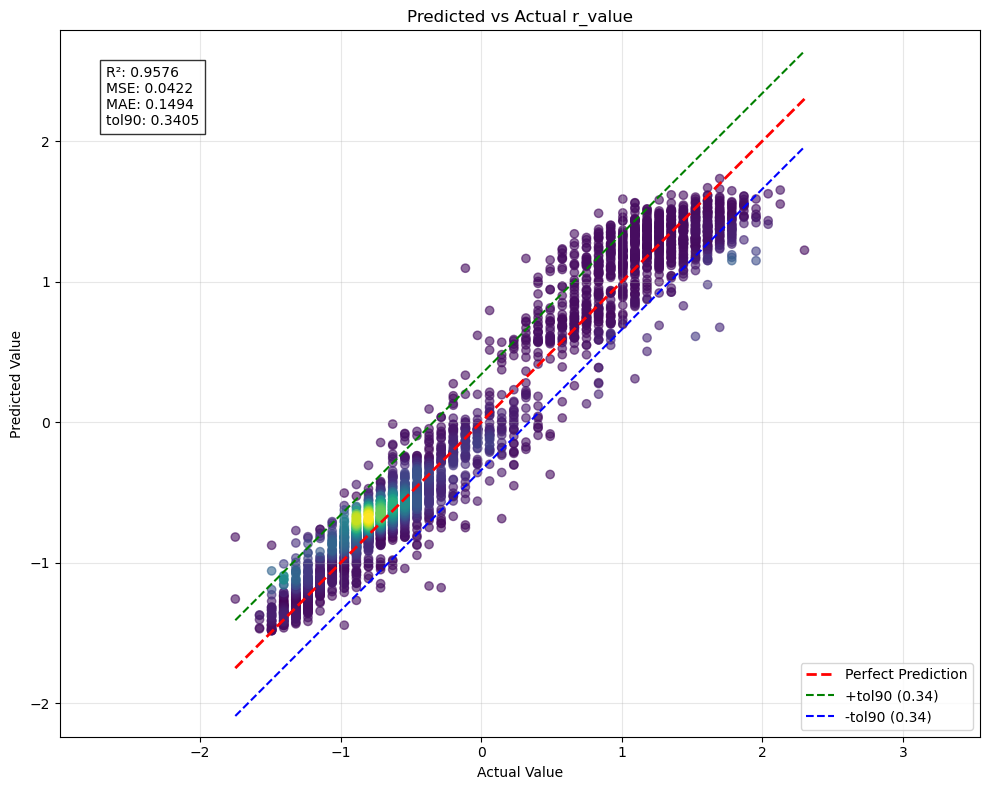

{'R2': 0.9575904491557501,
 'MSE': 0.042196411088404086,
 'MAE': 0.1494467211582525,
 'tol90': 0.34050708765634463}

In [84]:
plot_predicted_vs_actual(model_info, test_scaled_df)

XGB -----

In [8]:
def optimize_hyperparameters_xgb(X_train, y_train):

    param_grid = {
        'eta': [0.01, 0.1, 0.3],
        'lambda': [0, 0.1, 1, 10],
        'max_depth': [3, 4, 5, 6]
    }
    
    grid_search = GridSearchCV(
        estimator=XGBRegressor(random_state=42),
        param_grid=param_grid,
        cv=5,  # 5-fold cross-validation
        scoring='neg_mean_absolute_error',
        n_jobs=-1  # Use all available cores
    )
    
    grid_search.fit(X_train, y_train)
    
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_
    }

In [9]:
trained_models_xgb = train_optimized_model(train_scaled_df, model_type='xgb')

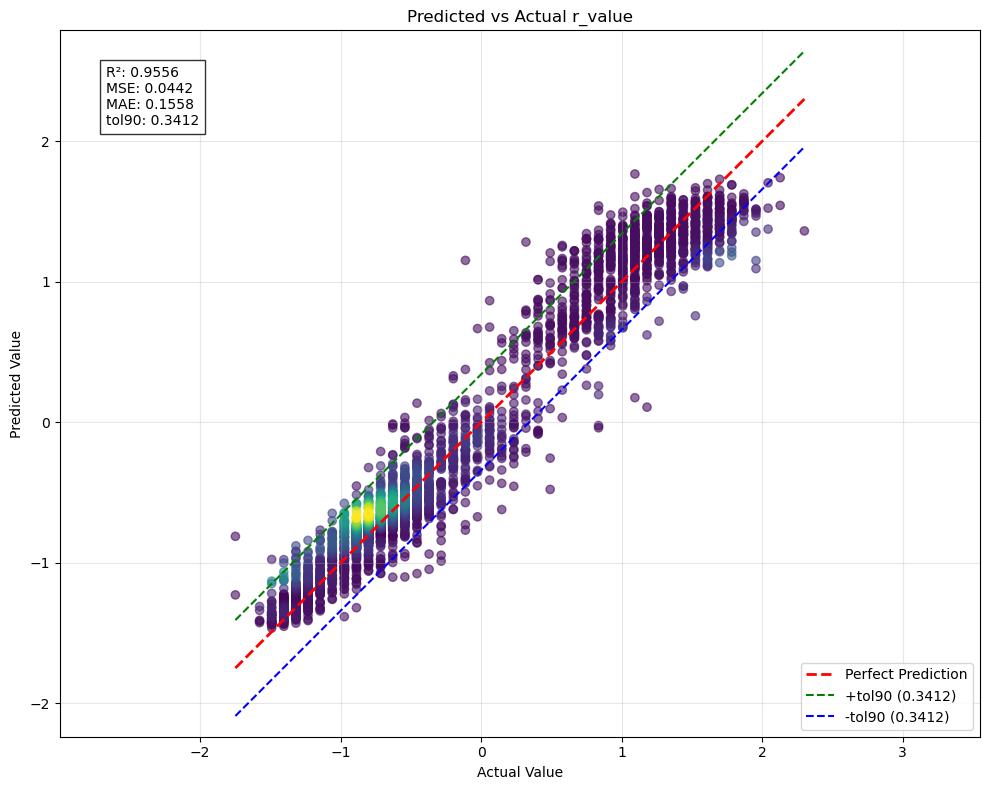

{'R2': 0.9555866919694271,
 'MSE': 0.04419009789414144,
 'MAE': 0.155763582711918,
 'tol90': 0.34122445909398547}

In [74]:
plot_predicted_vs_actual(trained_models_xgb, test_scaled_df)

ANN---- (from Millner paper)

In [25]:
class SteelPropertiesANN:
    def __init__(self, input_dim, target_column):
        self.input_dim = input_dim
        self.target_column = target_column
        self.best_model = None
        self.best_params = None
        self.best_score = float('inf')

    def build_model(self, config):
        hidden_layers = config['layers']
        learning_rate = config['learning_rate']
        l2_strength = config['l2_regularization']
        
        model = keras.Sequential()
        model.add(keras.layers.Input(shape=(self.input_dim,)))
        
        for units, activation in hidden_layers:
            model.add(keras.layers.Dense(
                units=units,
                activation=activation,
                kernel_regularizer=keras.regularizers.l2(l2_strength)
            ))
        
        model.add(keras.layers.Dense(1))
        
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=100,
            decay_rate=0.9,
            staircase=True
        )
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0),
            loss='mean_absolute_error',
            metrics=['mae', 'mse']
        )
        return model

    def generate_grid_configs(self, 
        layer_options=[(64, 'relu'), (128, 'relu'), (256, 'relu')],
        layer_depths=[2, 3, 4],
        learning_rates=[1e-2, 1e-3, 1e-4],
        l2_regularization=[1e-3, 1e-4, 1e-5],
        batch_sizes=[16, 32, 64]
    ):
        from itertools import product
        grid_configs = []
        
        for depth in layer_depths:
            for lr in learning_rates:
                for l2_reg in l2_regularization:
                    for batch_size in batch_sizes:
                        layer_combinations = list(product(layer_options, repeat=depth))
                        for layers in layer_combinations:
                            config = {
                                'layers': layers,
                                'learning_rate': lr,
                                'l2_regularization': l2_reg,
                                'batch_size': batch_size
                            }
                            grid_configs.append(config)
        
        return grid_configs

    def grid_search(self, train_scaled_df, grid_configs=None, epochs=100, max_configs=None):
        # Split training data into training and validation sets
        train_data, val_data = train_test_split(train_scaled_df, test_size=0.2, random_state=42)
    
        if grid_configs is None:
            grid_configs = self.generate_grid_configs()
        
        X_train = train_data.drop([self.target_column], axis=1)
        y_train = train_data[self.target_column]
        X_val = val_data.drop([self.target_column], axis=1)
        y_val = val_data[self.target_column]
        
        if max_configs:
            grid_configs = grid_configs[:max_configs]
        
        results = []
        for config in tqdm(grid_configs, desc="Training models"):
            tf.keras.backend.clear_session()
            model = self.build_model(config)
            batch_size = min(config['batch_size'], len(X_train))
            
            early_stopping = keras.callbacks.EarlyStopping(
                monitor='val_loss', 
                patience=10, 
                restore_best_weights=True,
                min_delta=1e-4
            )
            
            try:
                X_train = np.array(X_train, dtype=np.float32)
                y_train = np.array(y_train, dtype=np.float32)
                X_val = np.array(X_val, dtype=np.float32)
                y_val = np.array(y_val, dtype=np.float32)

                train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
                train_dataset = (train_dataset
                    .batch(batch_size, drop_remainder=False)
                    .repeat())
                
                val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
                val_dataset = val_dataset.batch(batch_size)
                
                steps_per_epoch = len(X_train) // batch_size
                
                history = model.fit(
                    train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[early_stopping],
                    verbose=0
                )
                
                val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
                
                result_entry = config.copy()
                result_entry.update({'val_loss': val_loss})
                results.append(result_entry)
                
                if val_loss < self.best_score:
                    self.best_score = val_loss
                    self.best_model = model
                    self.best_params = config
                
            except Exception as e:
                print(f"Error with config {config}: {str(e)}")
                continue
        
        return self.best_model, self.best_params

    def evaluate(self, test_scaled_df):
        if self.best_model is None:
            raise ValueError("No model has been trained. Call grid_search first.")
        
        X_test = test_scaled_df.drop([self.target_column], axis=1)
        y_test = test_scaled_df[self.target_column]
        
        y_pred = self.best_model.predict(X_test).flatten()
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        tol90_value = tol90(y_test, y_pred)
        
        # Create visualization
        plt.figure(figsize=(10, 8))
        plot_single_comparison(y_test, y_pred, "All Families", r2, mse, mae, tol90_value)
        plt.tight_layout()
        plt.show()
        
        return {
            'model': self.best_model,
            'MSE': mse,
            'MAE': mae,
            'R2': r2,
            'tol90': tol90_value,
            'Best Parameters': self.best_params
        }

In [ ]:
# # Create the ANN instance
# ann = SteelPropertiesANN(
#     input_dim=train_scaled_df.drop(['r_value'], axis=1).shape[1],
#     target_column='r_value'
# )

# configs = ann.generate_grid_configs(
#     layer_options=[(64, 'relu'), (128, 'relu'), (256, 'relu')],
#     layer_depths=[2, 3, 4],
#     learning_rates=[1e-3, 1e-4],
#     l2_regularization=[1e-3, 1e-4],
#     batch_sizes=[16, 32, 64]
# )

# best_model, best_params = ann.grid_search(train_scaled_df, grid_configs=configs)

# # Evaluate and visualize
# # metrics = ann.evaluate(test_scaled_df)
# print("Best Model Metrics:")
# print(best_params)

# best_model.save('model_mecomep2.h5')

Training models:   0%|          | 0/1404 [00:00<?, ?it/s]

Training models: 100%|██████████| 1404/1404 [7:42:09<00:00, 19.75s/it]  

Best Model Metrics:
{'layers': ((256, 'relu'), (64, 'relu'), (64, 'relu')), 'learning_rate': 0.001, 'l2_regularization': 0.0001, 'batch_size': 64}



c:\Users\A070050\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [75]:
# best_params_ann = {'layers': ((256, 'relu'), (64, 'relu'), (64, 'relu')), 'learning_rate': 0.001, 'l2_regularization': 0.0001, 'batch_size': 64}

model_ann = keras.models.load_model('model_mecomep2.h5')

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


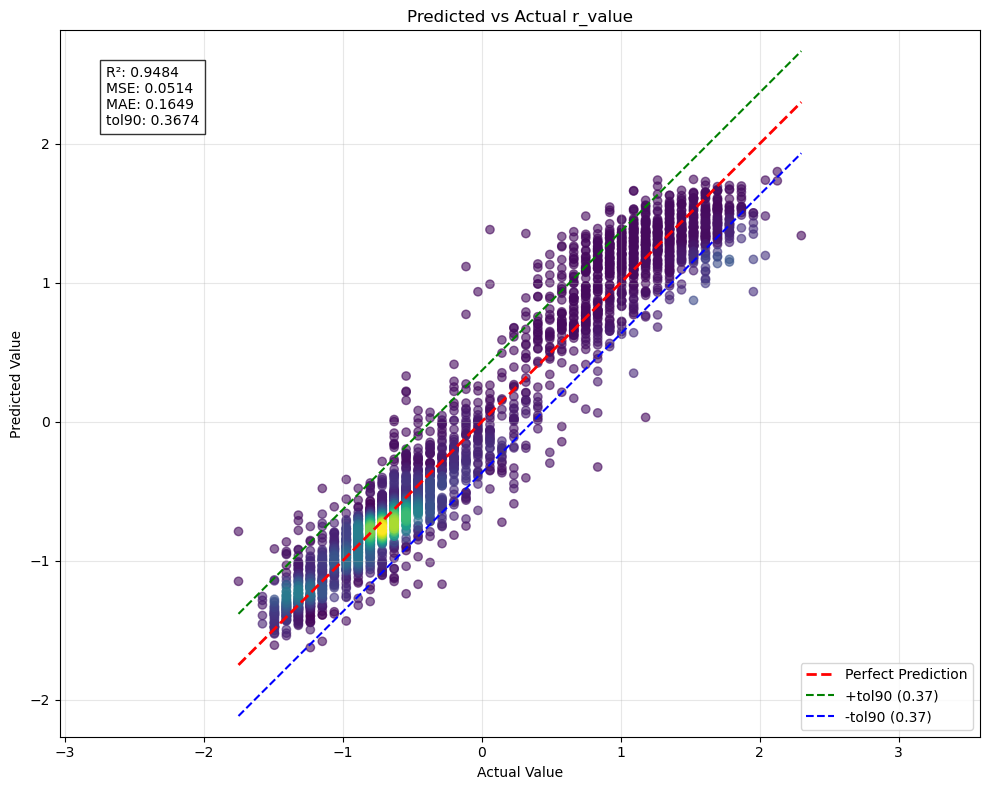

{'R2': 0.9483853070752407,
 'MSE': 0.05135529043571991,
 'MAE': 0.16493635648601848,
 'tol90': 0.3673562140252494}

In [85]:
plot_predicted_vs_actual(model_ann, test_scaled_df)

GPR ------

In [ ]:
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

def optimize_hyperparameters_gpr(X_train, y_train):

    
    # Define the parameter grid
    param_grid = {
        'kernel': [
            ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-2, 1e2)) * 
            Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5) + 
            WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e1))
        ]
    }
    
    gpr = GaussianProcessRegressor(normalize_y=True)
    
    # Grid search for the best hyperparameters
    grid_search = GridSearchCV(
        estimator=gpr,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_
    }


In [ ]:
trained_models_gpr = train_optimized_model(train_scaled_df, 'gpr')

{'R2': 0.940498904530411,
 'MSE': 0.0592020579011998,
 'MAE': 0.1762977421082072,
 'tol90': 0.38628006102153506}

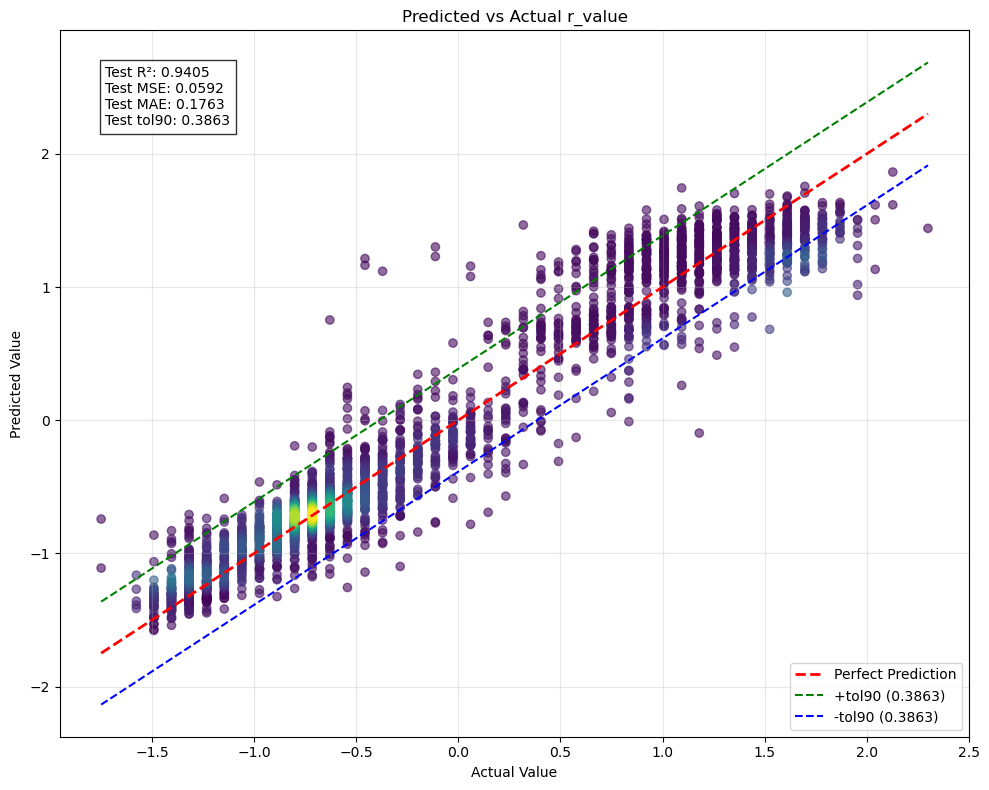

In [ ]:
plot_predicted_vs_actual(trained_models_gpr, test_scaled_df)

KNN -----

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def optimize_hyperparameters_knn(X_train, y_train):
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors to use
        'leaf_size': [20, 30, 40, 50],    # Leaf size passed to BallTree or KDTree
        'weights': ['uniform', 'distance']  # Weight function used in prediction
    }
    
    # Initialize the KNN regressor
    knn = KNeighborsRegressor()
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=knn,
        param_grid=param_grid,
        cv=5,  # 5-fold cross-validation
        scoring='neg_mean_absolute_error',
        n_jobs=-1  # Use all available cores
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Return the best parameters, estimator, and score
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_
    }

{'R2': 0.9332973716407997,
 'MSE': 0.06636739769441521,
 'MAE': 0.18483594473670553,
 'tol90': 0.4161785900761575}

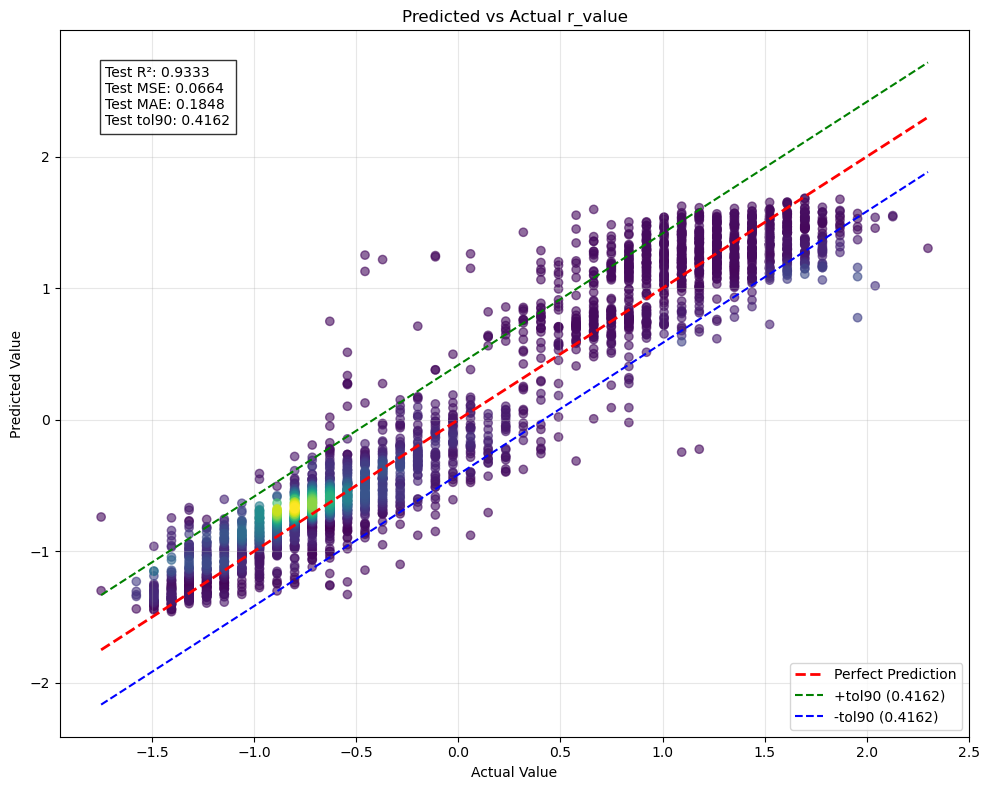

In [ ]:
trained_models_knn = train_optimized_model(train_scaled_df, 'knn')
plot_predicted_vs_actual(trained_models_knn, test_scaled_df)

SVR ----

In [ ]:
from sklearn.svm import SVR

def optimize_hyperparameters_svr(X_train, y_train):
    # Define the parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],        # Regularization parameter
        'epsilon': [0.01, 0.1, 0.5, 1] # Epsilon in the epsilon-SVR model
    }
    
    # Initialize the SVR model
    svr = SVR(kernel='rbf')
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=svr,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Return the best parameters, estimator, and score
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_
    }

{'R2': 0.9377914255433754,
 'MSE': 0.06189592977854506,
 'MAE': 0.17742747012557605,
 'tol90': 0.40054608835422856}

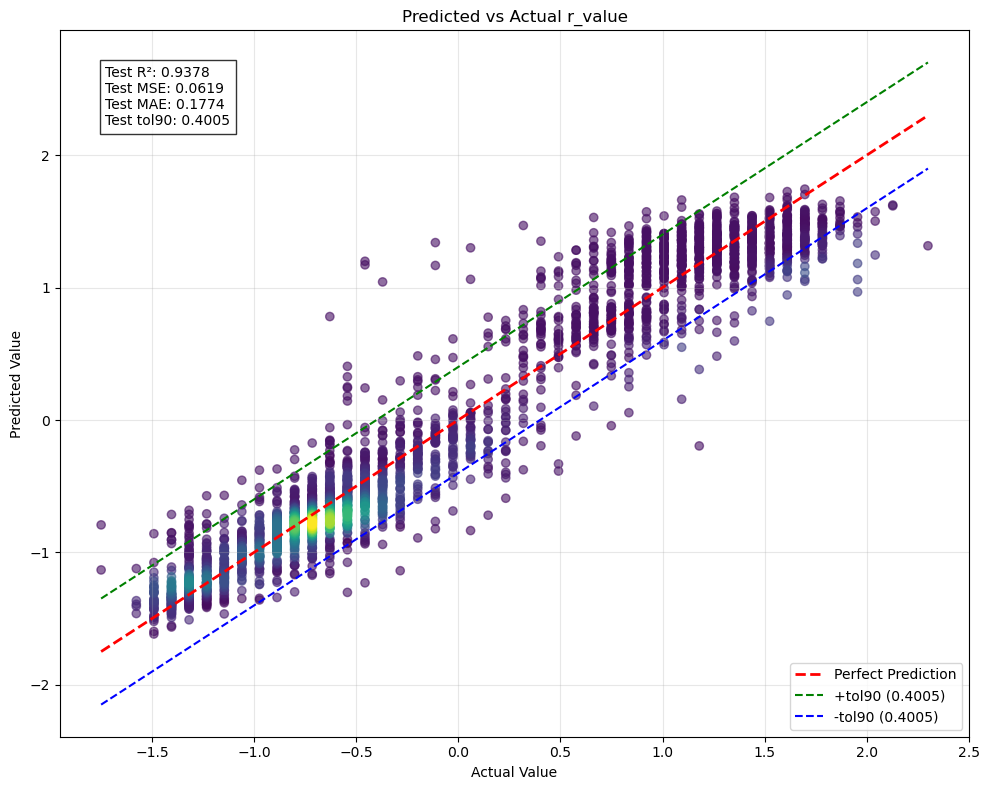

In [ ]:
trained_models_svr = train_optimized_model(train_scaled_df, 'svr')
plot_predicted_vs_actual(trained_models_svr, test_scaled_df)

In [10]:
from sklearn.linear_model import RidgeCV

def optimize_hyperparameters_ridge(X_train, y_train):
    # Define the range of alpha values to test
    alphas = [0.1, 1.0, 10.0, 100.0]
    
    # Initialize the RidgeCV model with the specified alphas
    ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
    
    # Fit the model to the training data
    ridge_cv.fit(X_train, y_train)
    
    # Retrieve the best alpha and the corresponding model
    best_alpha = ridge_cv.alpha_
    best_model = ridge_cv
    
    # Calculate the mean cross-validated score for the best alpha
    best_score = -ridge_cv.cv_values_.mean()
    
    return {
        'best_params': {'alpha': best_alpha},
        'best_estimator': best_model,
        'best_score': best_score
    }

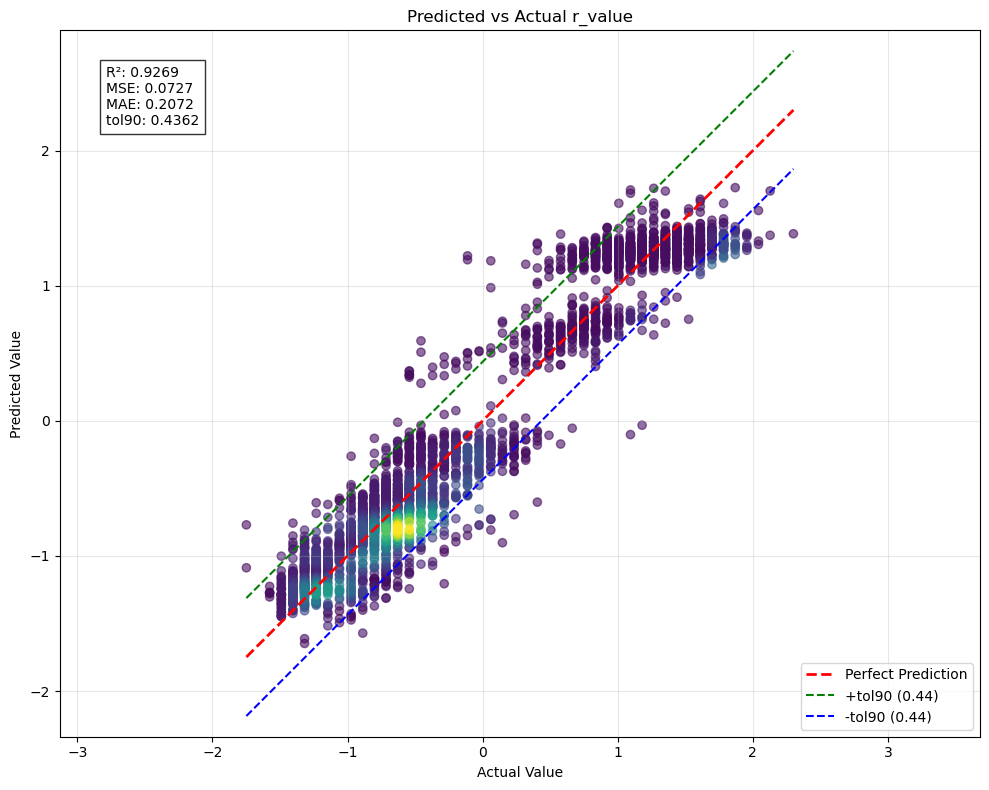

{'R2': 0.9269405565127695,
 'MSE': 0.07269226506545733,
 'MAE': 0.2072006624539791,
 'tol90': 0.4362270586898588}

In [11]:
trained_models_ridge = train_optimized_model(train_scaled_df, 'ridge')
plot_predicted_vs_actual(trained_models_ridge, test_scaled_df)

In [5]:
# labeling the features for each branch
features = [col for col in df.columns if col not in ['r_value', 'steel_family', 'steel_grade']]
features_dict = {
   'time': [col for col in features if 'time' in col.lower()], 
   'chemical': ['pct_al', 'pct_b', 'pct_c', 'pct_cr', 'pct_mn', 'pct_n', 'pct_nb', 'pct_si', 'pct_ti', 'pct_v', 'mfia_coil_frac_fer', 'mfia_et1_frac_fer', 'mfia_et2_frac_fer'],
   'model': ["rm", "ag", "a80", "n_value"]
}
features_dict['process'] = [col for col in features if col not in features_dict['time'] and col not in features_dict['chemical'] and col not in features_dict['model']]

In [6]:
class MultiBranchSteelRegressor(nn.Module):
    def __init__(self, chemical_dim, time_dim, process_dim, model_dim, hidden_units=64, dropout_rate=0.2):
        super().__init__()
        # Track which branches are active
        self.has_chemical = chemical_dim > 0
        self.has_time = time_dim > 0
        self.has_process = process_dim > 0
        self.has_model = model_dim > 0
        
        # Count active branches
        self.active_branches = sum([self.has_chemical, self.has_time, self.has_process, self.has_model])
        
        # Adjust hidden units for each branch
        self.branch_hidden = min(hidden_units, max(16, hidden_units // 2))
        
        # Creating branch
        def create_branch(input_dim):
            return nn.Sequential(
                nn.Linear(input_dim, self.branch_hidden),
                nn.BatchNorm1d(self.branch_hidden),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
        
        # Only create branches that have features
        if self.has_chemical:
            self.chemical_branch = create_branch(chemical_dim)
        if self.has_time:
            self.time_branch = create_branch(time_dim)
        if self.has_process:
            self.process_branch = create_branch(process_dim)
        if self.has_model:
            self.model_branch = create_branch(model_dim)
        
        # Combined input dimension based on active branches only
        combined_dim = self.branch_hidden * self.active_branches
        
        # Final layers after concatenation
        self.final_layers = nn.Sequential(
            nn.Linear(combined_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1)
        )
    
    def forward(self, chemical, time, process, model):
        features = []
        # Only process branches that have features
        if self.has_chemical:
            if chemical.dim() == 1:
                chemical = chemical.unsqueeze(0)
            features.append(self.chemical_branch(chemical))
        
        if self.has_time:
            if time.dim() == 1:
                time = time.unsqueeze(0)
            features.append(self.time_branch(time))
        
        if self.has_process:
            if process.dim() == 1:
                process = process.unsqueeze(0)
            features.append(self.process_branch(process))
        
        if self.has_model:
            if model.dim() == 1:
                model = model.unsqueeze(0)
            features.append(self.model_branch(model))
        
        # Concatenate only active features
        combined = torch.cat(features, dim=1) if len(features) > 1 else features[0]
        return self.final_layers(combined)

In [7]:
class EnhancedMultiBranchRegressor(nn.Module):
    def __init__(self, chemical_dim, time_dim, process_dim, model_dim=None, hyperparameters=None):
        super().__init__()

        default_params = {
            'batch_size': 32,
            'hidden_units': 64,
            'dropout_rate': 0.2,
            'cross_branch_dropout': 0,
            'final_layer_units': [128, 64],
            'final_layer_dropout': [0, 0],
            'activation': nn.ReLU(),
            'normalization': 'layer',
            'l2_lambda': 0.001,
            'residual_blocks': 2  # Number of residual blocks per branch
        }
        # Merge default and provided hyperparameters
        self.hp = {**default_params, **(hyperparameters or {})}

        def get_normalization(units):
            """Select normalization layer based on configuration."""
            if self.hp['normalization'] == 'batch':
                return nn.BatchNorm1d(units)
            elif self.hp['normalization'] == 'layer':
                return nn.LayerNorm(units)
            else:
                return nn.Identity()

        def create_residual_block(input_dim):
            """Create a residual block with adaptive configuration."""
            return ResidualBlock(
                input_dim, 
                self.hp['hidden_units'], 
                activation=self.hp['activation'], 
                dropout_rate=self.hp['dropout_rate'],
                normalization_func=get_normalization
            )

        def create_residual_branch(input_dim):
            """Create a residual branch with multiple blocks."""
            if input_dim <= 0:
                return None
            
            blocks = []
            # Initial projection layer
            blocks.append(nn.Linear(input_dim, self.hp['hidden_units']))
            blocks.append(get_normalization(self.hp['hidden_units']))
            blocks.append(self.hp['activation'])

            # Add residual blocks
            for _ in range(self.hp['residual_blocks']):
                blocks.append(create_residual_block(self.hp['hidden_units']))
            
            return nn.Sequential(*blocks)

        # Residual Branches
        self.branches = nn.ModuleDict({
            'chemical': create_residual_branch(chemical_dim),
            'time': create_residual_branch(time_dim),
            'process': create_residual_branch(process_dim),
            'model': create_residual_branch(model_dim)
        })

        # Cross-branch interaction
        active_branches = sum(1 for branch in self.branches.values() if branch is not None)
        cross_input_dim = self.hp['hidden_units'] * active_branches

        # Cross-branch interaction with residual connection
        self.cross_branch_interaction = nn.Sequential(
            nn.Linear(cross_input_dim, cross_input_dim // 2),
            self.hp['activation'],
            nn.Dropout(self.hp['cross_branch_dropout'])
        )

        # Dynamic final layers based on hyperparameters
        final_layers = []
        prev_units = cross_input_dim // 2
        for units, dropout_rate in zip(self.hp['final_layer_units'], self.hp['final_layer_dropout']):
            final_layers.extend([
                nn.Linear(prev_units, units),
                get_normalization(units),
                self.hp['activation'],
                nn.Dropout(dropout_rate)
            ])
            prev_units = units
        final_layers.append(nn.Linear(prev_units, 1))
        self.final_layers = nn.Sequential(*final_layers)

    def forward(self, chemical, time, process, model=None):
        processed_branches = []
        branch_inputs_and_names = [
            ('chemical', chemical, self.branches['chemical']),
            ('time', time, self.branches['time']),
            ('process', process, self.branches['process']),
            ('model', model, self.branches['model'])
        ]
        
        for name, input_tensor, branch in branch_inputs_and_names:
            if branch is not None and input_tensor is not None:
                processed_branches.append(branch(input_tensor))
        
        # Cross-branch interaction
        if len(processed_branches) > 1:
            cross_branch_features = torch.cat(processed_branches, dim=1)
            interaction_features = self.cross_branch_interaction(cross_branch_features)
        else:
            interaction_features = processed_branches[0]
        
        return self.final_layers(interaction_features)


# The ResidualBlock class remains unchanged
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, activation=nn.ReLU(), 
                 dropout_rate=0.2, normalization_func=None):
        super().__init__()
        
        # Use provided normalization function or default to Identity
        norm_func = normalization_func(hidden_dim) if normalization_func else nn.Identity()
        
        # Residual block with two linear layers
        self.block = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            norm_func,
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            norm_func
        )
        
        # Shortcut connection
        if input_dim != hidden_dim:
            self.shortcut = nn.Linear(input_dim, hidden_dim)
        else:
            self.shortcut = nn.Identity()
        
        # Final activation
        self.activation = activation

    def forward(self, x):
        # Residual connection
        residual = self.shortcut(x)
        out = self.block(x)
        
        # Combine residual and transformed features
        combined = residual + out
        return self.activation(combined)

In [8]:
def train_model_regular(df, features_dict, num_epochs, hyperparameters, use_l2=False):
    batch_size = hyperparameters['batch_size']
    
    # Initialize feature arrays and dimensions
    feature_arrays = {}
    feature_dims = {}
    
    # Process each feature category
    for category in ['chemical', 'time', 'process', 'model']:
        available_features = [col for col in features_dict[category] 
                            if col in df.columns]
        
        if available_features:
            feature_arrays[category] = df[available_features].values.astype(np.float32)
            feature_dims[category] = len(available_features)
        else:
            feature_arrays[category] = np.zeros((len(df), 0), dtype=np.float32)
            feature_dims[category] = 0
    
    # Prepare targets
    targets = df['r_value'].values
    
    # Split data
    split_data = train_test_split(
        feature_arrays['chemical'],
        feature_arrays['time'],
        feature_arrays['process'],
        feature_arrays['model'],
        targets,
        test_size=0.2,
        random_state=42
    )
    
    (X_train_chem, X_test_chem, X_train_time, X_test_time, 
     X_train_proc, X_test_proc, X_train_model, X_test_model, 
     y_train, y_test) = split_data
    
    # Convert to tensors
    train_tensors = {
        'chemical': torch.FloatTensor(X_train_chem),
        'time': torch.FloatTensor(X_train_time),
        'process': torch.FloatTensor(X_train_proc),
        'model': torch.FloatTensor(X_train_model)
    }
    
    test_tensors = {
        'chemical': torch.FloatTensor(X_test_chem),
        'time': torch.FloatTensor(X_test_time),
        'process': torch.FloatTensor(X_test_proc),
        'model': torch.FloatTensor(X_test_model)
    }
    
    y_train_tensor = torch.FloatTensor(y_train)
    y_test_tensor = torch.FloatTensor(y_test)
    
    # Create DataLoader
    train_dataset = TensorDataset(
        train_tensors['chemical'],
        train_tensors['time'],
        train_tensors['process'],
        train_tensors['model'],
        y_train_tensor
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # Initialize model
    model = MultiBranchSteelRegressor(
        chemical_dim=feature_dims['chemical'],
        time_dim=feature_dims['time'],
        process_dim=feature_dims['process'],
        model_dim=feature_dims['model'],
        hidden_units=hyperparameters['hidden_units'],
        dropout_rate=hyperparameters['dropout_rate']
    )
    
    if use_l2:
        weight_decay = 0.001
    else:
        weight_decay = 0.0
    
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=weight_decay)
    criterion = nn.L1Loss()
    
    # Training loop
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_chem, batch_time, batch_proc, batch_model, batch_targets in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_chem, batch_time, batch_proc, batch_model)
            loss = criterion(outputs, batch_targets.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred = model(
            test_tensors['chemical'],
            test_tensors['time'],
            test_tensors['process'],
            test_tensors['model']
        )
        test_loss = criterion(y_pred, y_test_tensor.unsqueeze(1)).item()
        y_pred_np = y_pred.numpy().flatten()
        r2 = r2_score(y_test, y_pred_np)
        mae = mean_absolute_error(y_test, y_pred_np)
        mse = mean_squared_error(y_test, y_pred_np)
        
        metrics = {
            'r2_score': r2,
            'mae': mae,
            'mse': mse,
            'test_loss': test_loss
        }
        print(f"Evaluation - Test Loss: {test_loss:.4f}, R2: {r2:.4f}")
    
    return model, metrics

In [9]:
def train_model_enhanced(df, features_dict, num_epochs, hyperparameters, use_l2=False):
    batch_size = hyperparameters.get('batch_size', 32)
    
    # Initialize feature arrays and dimensions
    feature_arrays = {}
    feature_dims = {}
    
    # Process each feature category with explicit type conversion
    for category in ['chemical', 'time', 'process', 'model']:
        available_features = [col for col in features_dict[category] 
                            if col in df.columns]
        
        if available_features:
            # Convert to float type and handle any non-numeric values
            feature_data = df[available_features].apply(pd.to_numeric, errors='coerce').fillna(0)
            feature_arrays[category] = feature_data.values.astype(np.float32)
            feature_dims[category] = len(available_features)
        else:
            feature_arrays[category] = np.zeros((len(df), 0), dtype=np.float32)
            feature_dims[category] = 0
    
    # Prepare targets
    targets = df['r_value'].astype(np.float32).values
    
    # Split data
    split_data = train_test_split(
        feature_arrays['chemical'],
        feature_arrays['time'],
        feature_arrays['process'],
        feature_arrays['model'],
        targets,
        test_size=0.2,
        random_state=42
    )
    
    (X_train_chem, X_test_chem, X_train_time, X_test_time, 
     X_train_proc, X_test_proc, X_train_model, X_test_model, 
     y_train, y_test) = split_data
    
    # Convert to tensors
    train_tensors = {
        'chemical': torch.FloatTensor(X_train_chem),
        'time': torch.FloatTensor(X_train_time),
        'process': torch.FloatTensor(X_train_proc),
        'model': torch.FloatTensor(X_train_model)
    }
    
    test_tensors = {
        'chemical': torch.FloatTensor(X_test_chem),
        'time': torch.FloatTensor(X_test_time),
        'process': torch.FloatTensor(X_test_proc),
        'model': torch.FloatTensor(X_test_model)
    }
    
    y_train_tensor = torch.FloatTensor(y_train)
    y_test_tensor = torch.FloatTensor(y_test)
    
    # Create DataLoader
    train_dataset = TensorDataset(
        train_tensors['chemical'],
        train_tensors['time'],
        train_tensors['process'],
        train_tensors['model'],
        y_train_tensor
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # Initialize model
    model = EnhancedMultiBranchRegressor(
        chemical_dim=feature_dims['chemical'],
        time_dim=feature_dims['time'],
        process_dim=feature_dims['process'],
        model_dim=feature_dims['model'],
        hyperparameters=hyperparameters
    )
    
    if use_l2:
        weight_decay = 0.001
    else:
        weight_decay = 0.0
    
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=weight_decay)
    criterion = nn.L1Loss()
    
    # Training loop
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_chem, batch_time, batch_proc, batch_model, batch_targets in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_chem, batch_time, batch_proc, batch_model)
            loss = criterion(outputs, batch_targets.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred = model(
            test_tensors['chemical'],
            test_tensors['time'],
            test_tensors['process'],
            test_tensors['model']
        )
        test_loss = criterion(y_pred, y_test_tensor.unsqueeze(1)).item()
        y_pred_np = y_pred.numpy().flatten()
        r2 = r2_score(y_test, y_pred_np)
        mae = mean_absolute_error(y_test, y_pred_np)
        mse = mean_squared_error(y_test, y_pred_np)
        
        evaluation_results = {
            'test_loss': test_loss,
            'r2_score': r2,
            'mae': mae,
            'mse': mse
        }
        print(f"Evaluation - Test Loss: {test_loss:.4f}, R2: {r2:.4f}")
    
    return model, evaluation_results

In [93]:
num_epochs=100

best_params_bmlp = {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'hidden_units': 128, 'learning_rate': 0.001}

In [94]:
best_mlp = train_model_regular(train_scaled_df, features_dict, num_epochs, best_params_bmlp)

Epoch [10/100], Loss: 0.1783
Epoch [20/100], Loss: 0.1624
Epoch [30/100], Loss: 0.1539
Epoch [40/100], Loss: 0.1478
Epoch [50/100], Loss: 0.1455
Epoch [60/100], Loss: 0.1401
Epoch [70/100], Loss: 0.1384
Epoch [80/100], Loss: 0.1332
Epoch [90/100], Loss: 0.1320
Epoch [100/100], Loss: 0.1289
Evaluation - Test Loss: 0.1533, R2: 0.9526


In [27]:
# from sklearn.model_selection import ParameterGrid

# param_grid = {
#     'learning_rate': [1e-3],
#     'batch_size': [32, 64],
#     'hidden_units': [64, 128],
#     'dropout_rate': [0, 0.2],
#     'cross_branch_dropout': [0, 0.2],
#     'final_layer_units': [
#         [128, 64],
#         [256, 128],
#     ],
#     'final_layer_dropout': [
#         [0, 0],
#         [0.2, 0.2],
#     ],
#     'normalization': ['batch', 'layer']
# }
# grid = ParameterGrid(param_grid)

In [28]:
# num_epochs = 50
# best_params = None
# best_results = {'avg_r2': float('-inf')}

# for params in tqdm(grid, desc="Grid Search Progress", leave=True):
#     print(f"Evaluating hyperparameters: {params}")
    
#     model, metrics = train_model_regular(train_scaled_df, features_dict, num_epochs, params)
    
#     # Now metrics contains r2_score directly
#     r2 = metrics['r2_score']
    
#     if best_params is None or r2 > best_results['avg_r2']:
#         best_results = {
#             'avg_r2': r2,
#             'metrics': metrics
#         }
#         best_params = params

# print(f"Best parameters found: {best_params}")
# print(f"Best R2 score: {best_results['avg_r2']:.4f}")

Grid Search Progress:   0%|          | 0/128 [00:00<?, ?it/s]

Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1797
Epoch [20/50], Loss: 0.1630
Epoch [30/50], Loss: 0.1557
Epoch [40/50], Loss: 0.1506


Grid Search Progress:   1%|          | 1/128 [00:59<2:05:31, 59.30s/it]

Epoch [50/50], Loss: 0.1499
Evaluation - Test Loss: 0.1526, R2: 0.9545
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1797
Epoch [20/50], Loss: 0.1668
Epoch [30/50], Loss: 0.1573
Epoch [40/50], Loss: 0.1526


Grid Search Progress:   2%|▏         | 2/128 [01:58<2:04:17, 59.19s/it]

Epoch [50/50], Loss: 0.1500
Evaluation - Test Loss: 0.1574, R2: 0.9528
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1757
Epoch [20/50], Loss: 0.1620
Epoch [30/50], Loss: 0.1558
Epoch [40/50], Loss: 0.1492


Grid Search Progress:   2%|▏         | 3/128 [02:59<2:05:32, 60.26s/it]

Epoch [50/50], Loss: 0.1461
Evaluation - Test Loss: 0.1527, R2: 0.9524
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1756
Epoch [20/50], Loss: 0.1630
Epoch [30/50], Loss: 0.1568
Epoch [40/50], Loss: 0.1505


Grid Search Progress:   3%|▎         | 4/128 [04:00<2:05:09, 60.56s/it]

Epoch [50/50], Loss: 0.1448
Evaluation - Test Loss: 0.1596, R2: 0.9499
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1792
Epoch [20/50], Loss: 0.1652
Epoch [30/50], Loss: 0.1601
Epoch [40/50], Loss: 0.1535


Grid Search Progress:   4%|▍         | 5/128 [05:00<2:03:14, 60.12s/it]

Epoch [50/50], Loss: 0.1485
Evaluation - Test Loss: 0.1605, R2: 0.9499
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1819
Epoch [20/50], Loss: 0.1647
Epoch [30/50], Loss: 0.1568
Epoch [40/50], Loss: 0.1518


Grid Search Progress:   5%|▍         | 6/128 [05:59<2:01:41, 59.85s/it]

Epoch [50/50], Loss: 0.1471
Evaluation - Test Loss: 0.1533, R2: 0.9543
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1813
Epoch [20/50], Loss: 0.1659
Epoch [30/50], Loss: 0.1580
Epoch [40/50], Loss: 0.1504


Grid Search Progress:   5%|▌         | 7/128 [07:01<2:01:42, 60.35s/it]

Epoch [50/50], Loss: 0.1469
Evaluation - Test Loss: 0.1577, R2: 0.9510
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1780
Epoch [20/50], Loss: 0.1628
Epoch [30/50], Loss: 0.1556
Epoch [40/50], Loss: 0.1491


Grid Search Progress:   6%|▋         | 8/128 [08:02<2:01:23, 60.70s/it]

Epoch [50/50], Loss: 0.1442
Evaluation - Test Loss: 0.1530, R2: 0.9531
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1783
Epoch [20/50], Loss: 0.1656
Epoch [30/50], Loss: 0.1583
Epoch [40/50], Loss: 0.1524


Grid Search Progress:   7%|▋         | 9/128 [09:02<1:59:49, 60.41s/it]

Epoch [50/50], Loss: 0.1469
Evaluation - Test Loss: 0.1581, R2: 0.9517
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1790
Epoch [20/50], Loss: 0.1657
Epoch [30/50], Loss: 0.1580
Epoch [40/50], Loss: 0.1534


Grid Search Progress:   8%|▊         | 10/128 [10:02<1:58:26, 60.23s/it]

Epoch [50/50], Loss: 0.1479
Evaluation - Test Loss: 0.1556, R2: 0.9516
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1811
Epoch [20/50], Loss: 0.1645
Epoch [30/50], Loss: 0.1550
Epoch [40/50], Loss: 0.1506


Grid Search Progress:   9%|▊         | 11/128 [11:02<1:57:48, 60.42s/it]

Epoch [50/50], Loss: 0.1461
Evaluation - Test Loss: 0.1572, R2: 0.9525
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1740
Epoch [20/50], Loss: 0.1616
Epoch [30/50], Loss: 0.1544
Epoch [40/50], Loss: 0.1493


Grid Search Progress:   9%|▉         | 12/128 [12:05<1:58:03, 61.07s/it]

Epoch [50/50], Loss: 0.1447
Evaluation - Test Loss: 0.1548, R2: 0.9524
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1794
Epoch [20/50], Loss: 0.1623
Epoch [30/50], Loss: 0.1557
Epoch [40/50], Loss: 0.1504


Grid Search Progress:  10%|█         | 13/128 [13:04<1:55:57, 60.50s/it]

Epoch [50/50], Loss: 0.1467
Evaluation - Test Loss: 0.1615, R2: 0.9501
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1833
Epoch [20/50], Loss: 0.1658
Epoch [30/50], Loss: 0.1567
Epoch [40/50], Loss: 0.1515


Grid Search Progress:  11%|█         | 14/128 [14:04<1:54:30, 60.27s/it]

Epoch [50/50], Loss: 0.1467
Evaluation - Test Loss: 0.1561, R2: 0.9507
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1755
Epoch [20/50], Loss: 0.1638
Epoch [30/50], Loss: 0.1545
Epoch [40/50], Loss: 0.1518


Grid Search Progress:  12%|█▏        | 15/128 [15:05<1:54:14, 60.66s/it]

Epoch [50/50], Loss: 0.1446
Evaluation - Test Loss: 0.1528, R2: 0.9538
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1792
Epoch [20/50], Loss: 0.1638
Epoch [30/50], Loss: 0.1543
Epoch [40/50], Loss: 0.1487


Grid Search Progress:  12%|█▎        | 16/128 [16:06<1:53:09, 60.62s/it]

Epoch [50/50], Loss: 0.1452
Evaluation - Test Loss: 0.1541, R2: 0.9532
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2413
Epoch [20/50], Loss: 0.2256
Epoch [30/50], Loss: 0.2116
Epoch [40/50], Loss: 0.2038


Grid Search Progress:  13%|█▎        | 17/128 [17:09<1:53:31, 61.36s/it]

Epoch [50/50], Loss: 0.2025
Evaluation - Test Loss: 0.1626, R2: 0.9488
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2399
Epoch [20/50], Loss: 0.2255
Epoch [30/50], Loss: 0.2164
Epoch [40/50], Loss: 0.2071


Grid Search Progress:  14%|█▍        | 18/128 [18:14<1:54:23, 62.39s/it]

Epoch [50/50], Loss: 0.2021
Evaluation - Test Loss: 0.1678, R2: 0.9473
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2276
Epoch [20/50], Loss: 0.2161
Epoch [30/50], Loss: 0.2036
Epoch [40/50], Loss: 0.2007


Grid Search Progress:  15%|█▍        | 19/128 [19:19<1:54:58, 63.29s/it]

Epoch [50/50], Loss: 0.2010
Evaluation - Test Loss: 0.1656, R2: 0.9468
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2346
Epoch [20/50], Loss: 0.2194
Epoch [30/50], Loss: 0.2088
Epoch [40/50], Loss: 0.2027


Grid Search Progress:  16%|█▌        | 20/128 [20:24<1:54:56, 63.86s/it]

Epoch [50/50], Loss: 0.2020
Evaluation - Test Loss: 0.1623, R2: 0.9497
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2416
Epoch [20/50], Loss: 0.2213
Epoch [30/50], Loss: 0.2136
Epoch [40/50], Loss: 0.2056


Grid Search Progress:  16%|█▋        | 21/128 [21:28<1:53:29, 63.64s/it]

Epoch [50/50], Loss: 0.2024
Evaluation - Test Loss: 0.1714, R2: 0.9457
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2358
Epoch [20/50], Loss: 0.2199
Epoch [30/50], Loss: 0.2136
Epoch [40/50], Loss: 0.2067


Grid Search Progress:  17%|█▋        | 22/128 [22:31<1:52:07, 63.47s/it]

Epoch [50/50], Loss: 0.2019
Evaluation - Test Loss: 0.1670, R2: 0.9472
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2343
Epoch [20/50], Loss: 0.2167
Epoch [30/50], Loss: 0.2073
Epoch [40/50], Loss: 0.2008


Grid Search Progress:  18%|█▊        | 23/128 [23:36<1:52:20, 64.19s/it]

Epoch [50/50], Loss: 0.1968
Evaluation - Test Loss: 0.1698, R2: 0.9449
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2331
Epoch [20/50], Loss: 0.2169
Epoch [30/50], Loss: 0.2072
Epoch [40/50], Loss: 0.2005


Grid Search Progress:  19%|█▉        | 24/128 [24:42<1:51:50, 64.52s/it]

Epoch [50/50], Loss: 0.1986
Evaluation - Test Loss: 0.1604, R2: 0.9512
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2394
Epoch [20/50], Loss: 0.2195
Epoch [30/50], Loss: 0.2171
Epoch [40/50], Loss: 0.2072


Grid Search Progress:  20%|█▉        | 25/128 [25:45<1:49:59, 64.08s/it]

Epoch [50/50], Loss: 0.2009
Evaluation - Test Loss: 0.1626, R2: 0.9498
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2427
Epoch [20/50], Loss: 0.2266
Epoch [30/50], Loss: 0.2129
Epoch [40/50], Loss: 0.2061


Grid Search Progress:  20%|██        | 26/128 [26:48<1:48:27, 63.80s/it]

Epoch [50/50], Loss: 0.2051
Evaluation - Test Loss: 0.1636, R2: 0.9482
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2332
Epoch [20/50], Loss: 0.2179
Epoch [30/50], Loss: 0.2049
Epoch [40/50], Loss: 0.2031


Grid Search Progress:  21%|██        | 27/128 [27:53<1:47:59, 64.15s/it]

Epoch [50/50], Loss: 0.1981
Evaluation - Test Loss: 0.1731, R2: 0.9438
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2265
Epoch [20/50], Loss: 0.2172
Epoch [30/50], Loss: 0.2055
Epoch [40/50], Loss: 0.2052


Grid Search Progress:  22%|██▏       | 28/128 [28:59<1:47:38, 64.58s/it]

Epoch [50/50], Loss: 0.1961
Evaluation - Test Loss: 0.1727, R2: 0.9434
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2350
Epoch [20/50], Loss: 0.2224
Epoch [30/50], Loss: 0.2112
Epoch [40/50], Loss: 0.2070


Grid Search Progress:  23%|██▎       | 29/128 [30:02<1:45:55, 64.20s/it]

Epoch [50/50], Loss: 0.2066
Evaluation - Test Loss: 0.1612, R2: 0.9503
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2480
Epoch [20/50], Loss: 0.2232
Epoch [30/50], Loss: 0.2105
Epoch [40/50], Loss: 0.2059


Grid Search Progress:  23%|██▎       | 30/128 [31:05<1:44:11, 63.80s/it]

Epoch [50/50], Loss: 0.2015
Evaluation - Test Loss: 0.1658, R2: 0.9487
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2347
Epoch [20/50], Loss: 0.2163
Epoch [30/50], Loss: 0.2076
Epoch [40/50], Loss: 0.2022


Grid Search Progress:  24%|██▍       | 31/128 [32:10<1:43:40, 64.13s/it]

Epoch [50/50], Loss: 0.1966
Evaluation - Test Loss: 0.1651, R2: 0.9492
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2365
Epoch [20/50], Loss: 0.2191
Epoch [30/50], Loss: 0.2073
Epoch [40/50], Loss: 0.2021


Grid Search Progress:  25%|██▌       | 32/128 [33:15<1:43:08, 64.47s/it]

Epoch [50/50], Loss: 0.1990
Evaluation - Test Loss: 0.1617, R2: 0.9489
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1793
Epoch [20/50], Loss: 0.1682
Epoch [30/50], Loss: 0.1591
Epoch [40/50], Loss: 0.1515


Grid Search Progress:  26%|██▌       | 33/128 [34:14<1:39:40, 62.96s/it]

Epoch [50/50], Loss: 0.1490
Evaluation - Test Loss: 0.1664, R2: 0.9464
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1798
Epoch [20/50], Loss: 0.1657
Epoch [30/50], Loss: 0.1573
Epoch [40/50], Loss: 0.1529


Grid Search Progress:  27%|██▋       | 34/128 [35:13<1:36:50, 61.81s/it]

Epoch [50/50], Loss: 0.1488
Evaluation - Test Loss: 0.1571, R2: 0.9513
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1754
Epoch [20/50], Loss: 0.1634
Epoch [30/50], Loss: 0.1561
Epoch [40/50], Loss: 0.1501


Grid Search Progress:  27%|██▋       | 35/128 [36:14<1:35:27, 61.58s/it]

Epoch [50/50], Loss: 0.1449
Evaluation - Test Loss: 0.1551, R2: 0.9517
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1779
Epoch [20/50], Loss: 0.1633
Epoch [30/50], Loss: 0.1538
Epoch [40/50], Loss: 0.1489


Grid Search Progress:  28%|██▊       | 36/128 [37:16<1:34:21, 61.54s/it]

Epoch [50/50], Loss: 0.1466
Evaluation - Test Loss: 0.1650, R2: 0.9457
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1820
Epoch [20/50], Loss: 0.1676
Epoch [30/50], Loss: 0.1580
Epoch [40/50], Loss: 0.1539


Grid Search Progress:  29%|██▉       | 37/128 [38:15<1:32:25, 60.94s/it]

Epoch [50/50], Loss: 0.1477
Evaluation - Test Loss: 0.1551, R2: 0.9502
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1783
Epoch [20/50], Loss: 0.1634
Epoch [30/50], Loss: 0.1561
Epoch [40/50], Loss: 0.1512


Grid Search Progress:  30%|██▉       | 38/128 [39:15<1:30:57, 60.64s/it]

Epoch [50/50], Loss: 0.1476
Evaluation - Test Loss: 0.1538, R2: 0.9524
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1790
Epoch [20/50], Loss: 0.1624
Epoch [30/50], Loss: 0.1563
Epoch [40/50], Loss: 0.1509


Grid Search Progress:  30%|███       | 39/128 [40:16<1:30:08, 60.77s/it]

Epoch [50/50], Loss: 0.1465
Evaluation - Test Loss: 0.1613, R2: 0.9471
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1742
Epoch [20/50], Loss: 0.1637
Epoch [30/50], Loss: 0.1565
Epoch [40/50], Loss: 0.1509


Grid Search Progress:  31%|███▏      | 40/128 [41:18<1:29:16, 60.86s/it]

Epoch [50/50], Loss: 0.1466
Evaluation - Test Loss: 0.1575, R2: 0.9511
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1796
Epoch [20/50], Loss: 0.1637
Epoch [30/50], Loss: 0.1587
Epoch [40/50], Loss: 0.1537


Grid Search Progress:  32%|███▏      | 41/128 [42:17<1:27:46, 60.54s/it]

Epoch [50/50], Loss: 0.1485
Evaluation - Test Loss: 0.1647, R2: 0.9487
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1797
Epoch [20/50], Loss: 0.1661
Epoch [30/50], Loss: 0.1584
Epoch [40/50], Loss: 0.1540


Grid Search Progress:  33%|███▎      | 42/128 [43:17<1:26:21, 60.25s/it]

Epoch [50/50], Loss: 0.1468
Evaluation - Test Loss: 0.1580, R2: 0.9518
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1764
Epoch [20/50], Loss: 0.1631
Epoch [30/50], Loss: 0.1529
Epoch [40/50], Loss: 0.1509


Grid Search Progress:  34%|███▎      | 43/128 [44:19<1:25:56, 60.66s/it]

Epoch [50/50], Loss: 0.1464
Evaluation - Test Loss: 0.1678, R2: 0.9452
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1772
Epoch [20/50], Loss: 0.1626
Epoch [30/50], Loss: 0.1573
Epoch [40/50], Loss: 0.1507


Grid Search Progress:  34%|███▍      | 44/128 [45:20<1:25:09, 60.82s/it]

Epoch [50/50], Loss: 0.1465
Evaluation - Test Loss: 0.1533, R2: 0.9537
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1824
Epoch [20/50], Loss: 0.1656
Epoch [30/50], Loss: 0.1581
Epoch [40/50], Loss: 0.1530


Grid Search Progress:  35%|███▌      | 45/128 [46:20<1:23:46, 60.56s/it]

Epoch [50/50], Loss: 0.1505
Evaluation - Test Loss: 0.1624, R2: 0.9491
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1777
Epoch [20/50], Loss: 0.1648
Epoch [30/50], Loss: 0.1572
Epoch [40/50], Loss: 0.1538


Grid Search Progress:  36%|███▌      | 46/128 [47:19<1:22:15, 60.19s/it]

Epoch [50/50], Loss: 0.1492
Evaluation - Test Loss: 0.1591, R2: 0.9513
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1782
Epoch [20/50], Loss: 0.1635
Epoch [30/50], Loss: 0.1555
Epoch [40/50], Loss: 0.1511


Grid Search Progress:  37%|███▋      | 47/128 [48:20<1:21:43, 60.54s/it]

Epoch [50/50], Loss: 0.1446
Evaluation - Test Loss: 0.1530, R2: 0.9550
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1771
Epoch [20/50], Loss: 0.1625
Epoch [30/50], Loss: 0.1545
Epoch [40/50], Loss: 0.1492


Grid Search Progress:  38%|███▊      | 48/128 [49:22<1:21:06, 60.84s/it]

Epoch [50/50], Loss: 0.1432
Evaluation - Test Loss: 0.1560, R2: 0.9515
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2396
Epoch [20/50], Loss: 0.2217
Epoch [30/50], Loss: 0.2165
Epoch [40/50], Loss: 0.2096


Grid Search Progress:  38%|███▊      | 49/128 [50:27<1:21:41, 62.04s/it]

Epoch [50/50], Loss: 0.2043
Evaluation - Test Loss: 0.1686, R2: 0.9484
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2394
Epoch [20/50], Loss: 0.2249
Epoch [30/50], Loss: 0.2139
Epoch [40/50], Loss: 0.2083


Grid Search Progress:  39%|███▉      | 50/128 [51:30<1:21:11, 62.45s/it]

Epoch [50/50], Loss: 0.2028
Evaluation - Test Loss: 0.1679, R2: 0.9470
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2426
Epoch [20/50], Loss: 0.2180
Epoch [30/50], Loss: 0.2093
Epoch [40/50], Loss: 0.2044


Grid Search Progress:  40%|███▉      | 51/128 [52:35<1:21:12, 63.28s/it]

Epoch [50/50], Loss: 0.1997
Evaluation - Test Loss: 0.1758, R2: 0.9458
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2325
Epoch [20/50], Loss: 0.2161
Epoch [30/50], Loss: 0.2080
Epoch [40/50], Loss: 0.2044


Grid Search Progress:  41%|████      | 52/128 [53:41<1:21:11, 64.10s/it]

Epoch [50/50], Loss: 0.1980
Evaluation - Test Loss: 0.1653, R2: 0.9492
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2429
Epoch [20/50], Loss: 0.2247
Epoch [30/50], Loss: 0.2172
Epoch [40/50], Loss: 0.2062


Grid Search Progress:  41%|████▏     | 53/128 [54:45<1:20:00, 64.01s/it]

Epoch [50/50], Loss: 0.2046
Evaluation - Test Loss: 0.1642, R2: 0.9491
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2382
Epoch [20/50], Loss: 0.2248
Epoch [30/50], Loss: 0.2186
Epoch [40/50], Loss: 0.2082


Grid Search Progress:  42%|████▏     | 54/128 [55:48<1:18:31, 63.67s/it]

Epoch [50/50], Loss: 0.2039
Evaluation - Test Loss: 0.1650, R2: 0.9481
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2399
Epoch [20/50], Loss: 0.2157
Epoch [30/50], Loss: 0.2051
Epoch [40/50], Loss: 0.2031


Grid Search Progress:  43%|████▎     | 55/128 [56:54<1:18:07, 64.21s/it]

Epoch [50/50], Loss: 0.1993
Evaluation - Test Loss: 0.1689, R2: 0.9465
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2322
Epoch [20/50], Loss: 0.2125
Epoch [30/50], Loss: 0.2080
Epoch [40/50], Loss: 0.2077


Grid Search Progress:  44%|████▍     | 56/128 [57:59<1:17:26, 64.53s/it]

Epoch [50/50], Loss: 0.1966
Evaluation - Test Loss: 0.1647, R2: 0.9496
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2365
Epoch [20/50], Loss: 0.2237
Epoch [30/50], Loss: 0.2110
Epoch [40/50], Loss: 0.2096


Grid Search Progress:  45%|████▍     | 57/128 [59:03<1:16:06, 64.32s/it]

Epoch [50/50], Loss: 0.2083
Evaluation - Test Loss: 0.1719, R2: 0.9457
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2417
Epoch [20/50], Loss: 0.2257
Epoch [30/50], Loss: 0.2171
Epoch [40/50], Loss: 0.2084


Grid Search Progress:  45%|████▌     | 58/128 [1:00:06<1:14:38, 63.98s/it]

Epoch [50/50], Loss: 0.2062
Evaluation - Test Loss: 0.1643, R2: 0.9483
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2382
Epoch [20/50], Loss: 0.2181
Epoch [30/50], Loss: 0.2083
Epoch [40/50], Loss: 0.2047


Grid Search Progress:  46%|████▌     | 59/128 [1:01:11<1:13:57, 64.32s/it]

Epoch [50/50], Loss: 0.1999
Evaluation - Test Loss: 0.1625, R2: 0.9502
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2348
Epoch [20/50], Loss: 0.2147
Epoch [30/50], Loss: 0.2087
Epoch [40/50], Loss: 0.2015


Grid Search Progress:  47%|████▋     | 60/128 [1:02:16<1:13:10, 64.57s/it]

Epoch [50/50], Loss: 0.2010
Evaluation - Test Loss: 0.1640, R2: 0.9466
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2393
Epoch [20/50], Loss: 0.2263
Epoch [30/50], Loss: 0.2156
Epoch [40/50], Loss: 0.2103


Grid Search Progress:  48%|████▊     | 61/128 [1:03:20<1:11:44, 64.24s/it]

Epoch [50/50], Loss: 0.2064
Evaluation - Test Loss: 0.1696, R2: 0.9466
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2414
Epoch [20/50], Loss: 0.2253
Epoch [30/50], Loss: 0.2126
Epoch [40/50], Loss: 0.2086


Grid Search Progress:  48%|████▊     | 62/128 [1:04:23<1:10:17, 63.90s/it]

Epoch [50/50], Loss: 0.2027
Evaluation - Test Loss: 0.1639, R2: 0.9489
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2346
Epoch [20/50], Loss: 0.2176
Epoch [30/50], Loss: 0.2051
Epoch [40/50], Loss: 0.2014


Grid Search Progress:  49%|████▉     | 63/128 [1:05:28<1:09:47, 64.43s/it]

Epoch [50/50], Loss: 0.1944
Evaluation - Test Loss: 0.1628, R2: 0.9497
Evaluating hyperparameters: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2315
Epoch [20/50], Loss: 0.2162
Epoch [30/50], Loss: 0.2041
Epoch [40/50], Loss: 0.2038


Grid Search Progress:  50%|█████     | 64/128 [1:06:34<1:09:00, 64.69s/it]

Epoch [50/50], Loss: 0.2014
Evaluation - Test Loss: 0.1664, R2: 0.9479
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1731
Epoch [20/50], Loss: 0.1589
Epoch [30/50], Loss: 0.1510
Epoch [40/50], Loss: 0.1460


Grid Search Progress:  51%|█████     | 65/128 [1:07:09<58:32, 55.76s/it]  

Epoch [50/50], Loss: 0.1384
Evaluation - Test Loss: 0.1636, R2: 0.9500
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1691
Epoch [20/50], Loss: 0.1587
Epoch [30/50], Loss: 0.1506
Epoch [40/50], Loss: 0.1423


Grid Search Progress:  52%|█████▏    | 66/128 [1:07:44<51:13, 49.57s/it]

Epoch [50/50], Loss: 0.1375
Evaluation - Test Loss: 0.1571, R2: 0.9518
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1713
Epoch [20/50], Loss: 0.1573
Epoch [30/50], Loss: 0.1481
Epoch [40/50], Loss: 0.1387


Grid Search Progress:  52%|█████▏    | 67/128 [1:08:20<46:21, 45.60s/it]

Epoch [50/50], Loss: 0.1344
Evaluation - Test Loss: 0.1573, R2: 0.9523
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1750
Epoch [20/50], Loss: 0.1520
Epoch [30/50], Loss: 0.1454
Epoch [40/50], Loss: 0.1391


Grid Search Progress:  53%|█████▎    | 68/128 [1:08:57<43:06, 43.11s/it]

Epoch [50/50], Loss: 0.1350
Evaluation - Test Loss: 0.1558, R2: 0.9517
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1713
Epoch [20/50], Loss: 0.1578
Epoch [30/50], Loss: 0.1495
Epoch [40/50], Loss: 0.1447


Grid Search Progress:  54%|█████▍    | 69/128 [1:09:32<39:59, 40.67s/it]

Epoch [50/50], Loss: 0.1371
Evaluation - Test Loss: 0.1567, R2: 0.9521
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1722
Epoch [20/50], Loss: 0.1602
Epoch [30/50], Loss: 0.1493
Epoch [40/50], Loss: 0.1432


Grid Search Progress:  55%|█████▍    | 70/128 [1:10:07<37:40, 38.97s/it]

Epoch [50/50], Loss: 0.1378
Evaluation - Test Loss: 0.1530, R2: 0.9546
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1744
Epoch [20/50], Loss: 0.1584
Epoch [30/50], Loss: 0.1479
Epoch [40/50], Loss: 0.1396


Grid Search Progress:  55%|█████▌    | 71/128 [1:10:44<36:15, 38.17s/it]

Epoch [50/50], Loss: 0.1336
Evaluation - Test Loss: 0.1572, R2: 0.9516
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1716
Epoch [20/50], Loss: 0.1556
Epoch [30/50], Loss: 0.1454
Epoch [40/50], Loss: 0.1411


Grid Search Progress:  56%|█████▋    | 72/128 [1:11:20<35:06, 37.62s/it]

Epoch [50/50], Loss: 0.1342
Evaluation - Test Loss: 0.1553, R2: 0.9530
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1729
Epoch [20/50], Loss: 0.1549
Epoch [30/50], Loss: 0.1461
Epoch [40/50], Loss: 0.1401


Grid Search Progress:  57%|█████▋    | 73/128 [1:11:55<33:46, 36.85s/it]

Epoch [50/50], Loss: 0.1345
Evaluation - Test Loss: 0.1622, R2: 0.9496
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1765
Epoch [20/50], Loss: 0.1600
Epoch [30/50], Loss: 0.1508
Epoch [40/50], Loss: 0.1448


Grid Search Progress:  58%|█████▊    | 74/128 [1:12:30<32:47, 36.43s/it]

Epoch [50/50], Loss: 0.1394
Evaluation - Test Loss: 0.1521, R2: 0.9538
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1737
Epoch [20/50], Loss: 0.1581
Epoch [30/50], Loss: 0.1470
Epoch [40/50], Loss: 0.1406


Grid Search Progress:  59%|█████▊    | 75/128 [1:13:07<32:09, 36.41s/it]

Epoch [50/50], Loss: 0.1352
Evaluation - Test Loss: 0.1629, R2: 0.9484
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1688
Epoch [20/50], Loss: 0.1536
Epoch [30/50], Loss: 0.1486
Epoch [40/50], Loss: 0.1384


Grid Search Progress:  59%|█████▉    | 76/128 [1:13:43<31:37, 36.48s/it]

Epoch [50/50], Loss: 0.1326
Evaluation - Test Loss: 0.1575, R2: 0.9506
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1736
Epoch [20/50], Loss: 0.1591
Epoch [30/50], Loss: 0.1499
Epoch [40/50], Loss: 0.1432


Grid Search Progress:  60%|██████    | 77/128 [1:14:19<30:40, 36.08s/it]

Epoch [50/50], Loss: 0.1377
Evaluation - Test Loss: 0.1571, R2: 0.9517
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1744
Epoch [20/50], Loss: 0.1576
Epoch [30/50], Loss: 0.1488
Epoch [40/50], Loss: 0.1424


Grid Search Progress:  61%|██████    | 78/128 [1:14:54<29:51, 35.84s/it]

Epoch [50/50], Loss: 0.1365
Evaluation - Test Loss: 0.1516, R2: 0.9545
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1716
Epoch [20/50], Loss: 0.1538
Epoch [30/50], Loss: 0.1460
Epoch [40/50], Loss: 0.1408


Grid Search Progress:  62%|██████▏   | 79/128 [1:15:30<29:21, 35.95s/it]

Epoch [50/50], Loss: 0.1332
Evaluation - Test Loss: 0.1613, R2: 0.9515
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1724
Epoch [20/50], Loss: 0.1561
Epoch [30/50], Loss: 0.1438
Epoch [40/50], Loss: 0.1405


Grid Search Progress:  62%|██████▎   | 80/128 [1:16:06<28:51, 36.06s/it]

Epoch [50/50], Loss: 0.1330
Evaluation - Test Loss: 0.1583, R2: 0.9518
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2272
Epoch [20/50], Loss: 0.2156
Epoch [30/50], Loss: 0.2124
Epoch [40/50], Loss: 0.2008


Grid Search Progress:  63%|██████▎   | 81/128 [1:16:44<28:31, 36.41s/it]

Epoch [50/50], Loss: 0.1995
Evaluation - Test Loss: 0.1637, R2: 0.9479
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2289
Epoch [20/50], Loss: 0.2154
Epoch [30/50], Loss: 0.2120
Epoch [40/50], Loss: 0.2018


Grid Search Progress:  64%|██████▍   | 82/128 [1:17:21<28:08, 36.72s/it]

Epoch [50/50], Loss: 0.1997
Evaluation - Test Loss: 0.1616, R2: 0.9503
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2203
Epoch [20/50], Loss: 0.2125
Epoch [30/50], Loss: 0.1982
Epoch [40/50], Loss: 0.1948


Grid Search Progress:  65%|██████▍   | 83/128 [1:18:00<27:59, 37.32s/it]

Epoch [50/50], Loss: 0.1880
Evaluation - Test Loss: 0.1597, R2: 0.9506
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2189
Epoch [20/50], Loss: 0.2056
Epoch [30/50], Loss: 0.2033
Epoch [40/50], Loss: 0.1937


Grid Search Progress:  66%|██████▌   | 84/128 [1:18:38<27:39, 37.71s/it]

Epoch [50/50], Loss: 0.1902
Evaluation - Test Loss: 0.1592, R2: 0.9519
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2314
Epoch [20/50], Loss: 0.2173
Epoch [30/50], Loss: 0.2101
Epoch [40/50], Loss: 0.2046


Grid Search Progress:  66%|██████▋   | 85/128 [1:19:21<28:05, 39.19s/it]

Epoch [50/50], Loss: 0.1998
Evaluation - Test Loss: 0.1649, R2: 0.9485
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2261
Epoch [20/50], Loss: 0.2120
Epoch [30/50], Loss: 0.2074
Epoch [40/50], Loss: 0.1983


Grid Search Progress:  67%|██████▋   | 86/128 [1:19:59<27:16, 38.96s/it]

Epoch [50/50], Loss: 0.1948
Evaluation - Test Loss: 0.1626, R2: 0.9488
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2206
Epoch [20/50], Loss: 0.2109
Epoch [30/50], Loss: 0.2022
Epoch [40/50], Loss: 0.1970


Grid Search Progress:  68%|██████▊   | 87/128 [1:20:51<29:13, 42.77s/it]

Epoch [50/50], Loss: 0.1922
Evaluation - Test Loss: 0.1603, R2: 0.9499
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2182
Epoch [20/50], Loss: 0.2090
Epoch [30/50], Loss: 0.2013
Epoch [40/50], Loss: 0.1954


Grid Search Progress:  69%|██████▉   | 88/128 [1:21:41<29:58, 44.96s/it]

Epoch [50/50], Loss: 0.1919
Evaluation - Test Loss: 0.1624, R2: 0.9491
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2271
Epoch [20/50], Loss: 0.2126
Epoch [30/50], Loss: 0.2082
Epoch [40/50], Loss: 0.2002


Grid Search Progress:  70%|██████▉   | 89/128 [1:22:30<29:57, 46.09s/it]

Epoch [50/50], Loss: 0.1991
Evaluation - Test Loss: 0.1626, R2: 0.9484
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2261
Epoch [20/50], Loss: 0.2165
Epoch [30/50], Loss: 0.2138
Epoch [40/50], Loss: 0.2000


Grid Search Progress:  70%|███████   | 90/128 [1:23:18<29:30, 46.58s/it]

Epoch [50/50], Loss: 0.2021
Evaluation - Test Loss: 0.1629, R2: 0.9492
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2234
Epoch [20/50], Loss: 0.2047
Epoch [30/50], Loss: 0.2012
Epoch [40/50], Loss: 0.1944


Grid Search Progress:  71%|███████   | 91/128 [1:24:08<29:29, 47.82s/it]

Epoch [50/50], Loss: 0.1923
Evaluation - Test Loss: 0.1656, R2: 0.9483
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2240
Epoch [20/50], Loss: 0.2057
Epoch [30/50], Loss: 0.2031
Epoch [40/50], Loss: 0.1930


Grid Search Progress:  72%|███████▏  | 92/128 [1:24:59<29:11, 48.65s/it]

Epoch [50/50], Loss: 0.1911
Evaluation - Test Loss: 0.1590, R2: 0.9509
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2258
Epoch [20/50], Loss: 0.2168
Epoch [30/50], Loss: 0.2072
Epoch [40/50], Loss: 0.2080


Grid Search Progress:  73%|███████▎  | 93/128 [1:25:47<28:14, 48.41s/it]

Epoch [50/50], Loss: 0.2011
Evaluation - Test Loss: 0.1645, R2: 0.9489
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2254
Epoch [20/50], Loss: 0.2114
Epoch [30/50], Loss: 0.2061
Epoch [40/50], Loss: 0.2023


Grid Search Progress:  73%|███████▎  | 94/128 [1:26:35<27:26, 48.44s/it]

Epoch [50/50], Loss: 0.1969
Evaluation - Test Loss: 0.1606, R2: 0.9496
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2231
Epoch [20/50], Loss: 0.2097
Epoch [30/50], Loss: 0.2035
Epoch [40/50], Loss: 0.1971


Grid Search Progress:  74%|███████▍  | 95/128 [1:27:25<26:48, 48.73s/it]

Epoch [50/50], Loss: 0.1916
Evaluation - Test Loss: 0.1609, R2: 0.9505
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2215
Epoch [20/50], Loss: 0.2083
Epoch [30/50], Loss: 0.2015
Epoch [40/50], Loss: 0.1909


Grid Search Progress:  75%|███████▌  | 96/128 [1:28:15<26:10, 49.09s/it]

Epoch [50/50], Loss: 0.1912
Evaluation - Test Loss: 0.1618, R2: 0.9511
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1738
Epoch [20/50], Loss: 0.1588
Epoch [30/50], Loss: 0.1494
Epoch [40/50], Loss: 0.1432


Grid Search Progress:  76%|███████▌  | 97/128 [1:29:01<24:54, 48.20s/it]

Epoch [50/50], Loss: 0.1394
Evaluation - Test Loss: 0.1606, R2: 0.9517
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1748
Epoch [20/50], Loss: 0.1603
Epoch [30/50], Loss: 0.1508
Epoch [40/50], Loss: 0.1435


Grid Search Progress:  77%|███████▋  | 98/128 [1:29:51<24:24, 48.83s/it]

Epoch [50/50], Loss: 0.1396
Evaluation - Test Loss: 0.1545, R2: 0.9516
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1709
Epoch [20/50], Loss: 0.1550
Epoch [30/50], Loss: 0.1465
Epoch [40/50], Loss: 0.1381


Grid Search Progress:  77%|███████▋  | 99/128 [1:30:38<23:22, 48.35s/it]

Epoch [50/50], Loss: 0.1342
Evaluation - Test Loss: 0.1557, R2: 0.9515
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1688
Epoch [20/50], Loss: 0.1513
Epoch [30/50], Loss: 0.1444
Epoch [40/50], Loss: 0.1376


Grid Search Progress:  78%|███████▊  | 100/128 [1:31:26<22:24, 48.03s/it]

Epoch [50/50], Loss: 0.1324
Evaluation - Test Loss: 0.1552, R2: 0.9531
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1755
Epoch [20/50], Loss: 0.1591
Epoch [30/50], Loss: 0.1523
Epoch [40/50], Loss: 0.1443


Grid Search Progress:  79%|███████▉  | 101/128 [1:32:11<21:12, 47.13s/it]

Epoch [50/50], Loss: 0.1390
Evaluation - Test Loss: 0.1618, R2: 0.9493
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1747
Epoch [20/50], Loss: 0.1571
Epoch [30/50], Loss: 0.1460
Epoch [40/50], Loss: 0.1422


Grid Search Progress:  80%|███████▉  | 102/128 [1:32:56<20:10, 46.57s/it]

Epoch [50/50], Loss: 0.1366
Evaluation - Test Loss: 0.1575, R2: 0.9514
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1726
Epoch [20/50], Loss: 0.1545
Epoch [30/50], Loss: 0.1455
Epoch [40/50], Loss: 0.1389


Grid Search Progress:  80%|████████  | 103/128 [1:33:43<19:29, 46.77s/it]

Epoch [50/50], Loss: 0.1348
Evaluation - Test Loss: 0.1576, R2: 0.9515
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1697
Epoch [20/50], Loss: 0.1558
Epoch [30/50], Loss: 0.1469
Epoch [40/50], Loss: 0.1399


Grid Search Progress:  81%|████████▏ | 104/128 [1:34:30<18:44, 46.86s/it]

Epoch [50/50], Loss: 0.1352
Evaluation - Test Loss: 0.1560, R2: 0.9524
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1760
Epoch [20/50], Loss: 0.1574
Epoch [30/50], Loss: 0.1503
Epoch [40/50], Loss: 0.1448


Grid Search Progress:  82%|████████▏ | 105/128 [1:35:16<17:49, 46.51s/it]

Epoch [50/50], Loss: 0.1373
Evaluation - Test Loss: 0.1560, R2: 0.9527
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1726
Epoch [20/50], Loss: 0.1576
Epoch [30/50], Loss: 0.1479
Epoch [40/50], Loss: 0.1432


Grid Search Progress:  83%|████████▎ | 106/128 [1:36:01<16:54, 46.12s/it]

Epoch [50/50], Loss: 0.1379
Evaluation - Test Loss: 0.1565, R2: 0.9514
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1707
Epoch [20/50], Loss: 0.1570
Epoch [30/50], Loss: 0.1466
Epoch [40/50], Loss: 0.1390


Grid Search Progress:  84%|████████▎ | 107/128 [1:36:49<16:20, 46.68s/it]

Epoch [50/50], Loss: 0.1337
Evaluation - Test Loss: 0.1597, R2: 0.9492
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1671
Epoch [20/50], Loss: 0.1583
Epoch [30/50], Loss: 0.1457
Epoch [40/50], Loss: 0.1400


Grid Search Progress:  84%|████████▍ | 108/128 [1:37:37<15:38, 46.93s/it]

Epoch [50/50], Loss: 0.1331
Evaluation - Test Loss: 0.1560, R2: 0.9513
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1758
Epoch [20/50], Loss: 0.1570
Epoch [30/50], Loss: 0.1454
Epoch [40/50], Loss: 0.1425


Grid Search Progress:  85%|████████▌ | 109/128 [1:38:23<14:46, 46.68s/it]

Epoch [50/50], Loss: 0.1363
Evaluation - Test Loss: 0.1570, R2: 0.9522
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1777
Epoch [20/50], Loss: 0.1600
Epoch [30/50], Loss: 0.1483
Epoch [40/50], Loss: 0.1435


Grid Search Progress:  86%|████████▌ | 110/128 [1:39:09<14:00, 46.71s/it]

Epoch [50/50], Loss: 0.1364
Evaluation - Test Loss: 0.1604, R2: 0.9494
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.1734
Epoch [20/50], Loss: 0.1555
Epoch [30/50], Loss: 0.1456
Epoch [40/50], Loss: 0.1402


Grid Search Progress:  87%|████████▋ | 111/128 [1:39:57<13:20, 47.08s/it]

Epoch [50/50], Loss: 0.1361
Evaluation - Test Loss: 0.1566, R2: 0.9514
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.1732
Epoch [20/50], Loss: 0.1544
Epoch [30/50], Loss: 0.1466
Epoch [40/50], Loss: 0.1384


Grid Search Progress:  88%|████████▊ | 112/128 [1:40:40<12:12, 45.79s/it]

Epoch [50/50], Loss: 0.1331
Evaluation - Test Loss: 0.1556, R2: 0.9506
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2300
Epoch [20/50], Loss: 0.2156
Epoch [30/50], Loss: 0.2098
Epoch [40/50], Loss: 0.2010


Grid Search Progress:  88%|████████▊ | 113/128 [1:41:17<10:47, 43.13s/it]

Epoch [50/50], Loss: 0.1993
Evaluation - Test Loss: 0.1665, R2: 0.9478
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2283
Epoch [20/50], Loss: 0.2116
Epoch [30/50], Loss: 0.2080
Epoch [40/50], Loss: 0.2045


Grid Search Progress:  89%|████████▉ | 114/128 [1:41:55<09:40, 41.46s/it]

Epoch [50/50], Loss: 0.1991
Evaluation - Test Loss: 0.1629, R2: 0.9489
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2166
Epoch [20/50], Loss: 0.2055
Epoch [30/50], Loss: 0.2008
Epoch [40/50], Loss: 0.1919


Grid Search Progress:  90%|████████▉ | 115/128 [1:42:34<08:52, 40.97s/it]

Epoch [50/50], Loss: 0.1928
Evaluation - Test Loss: 0.1578, R2: 0.9507
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2236
Epoch [20/50], Loss: 0.2063
Epoch [30/50], Loss: 0.2034
Epoch [40/50], Loss: 0.1957


Grid Search Progress:  91%|█████████ | 116/128 [1:43:13<08:02, 40.24s/it]

Epoch [50/50], Loss: 0.1881
Evaluation - Test Loss: 0.1599, R2: 0.9502
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2286
Epoch [20/50], Loss: 0.2150
Epoch [30/50], Loss: 0.2081
Epoch [40/50], Loss: 0.2020


Grid Search Progress:  91%|█████████▏| 117/128 [1:43:51<07:13, 39.44s/it]

Epoch [50/50], Loss: 0.2004
Evaluation - Test Loss: 0.1607, R2: 0.9496
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2296
Epoch [20/50], Loss: 0.2128
Epoch [30/50], Loss: 0.2098
Epoch [40/50], Loss: 0.2063


Grid Search Progress:  92%|█████████▏| 118/128 [1:44:28<06:27, 38.75s/it]

Epoch [50/50], Loss: 0.1983
Evaluation - Test Loss: 0.1637, R2: 0.9475
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2234
Epoch [20/50], Loss: 0.2083
Epoch [30/50], Loss: 0.2004
Epoch [40/50], Loss: 0.1948


Grid Search Progress:  93%|█████████▎| 119/128 [1:45:07<05:48, 38.77s/it]

Epoch [50/50], Loss: 0.1901
Evaluation - Test Loss: 0.1570, R2: 0.9525
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0, 0], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2240
Epoch [20/50], Loss: 0.2084
Epoch [30/50], Loss: 0.2037
Epoch [40/50], Loss: 0.1959


Grid Search Progress:  94%|█████████▍| 120/128 [1:45:45<05:09, 38.73s/it]

Epoch [50/50], Loss: 0.1880
Evaluation - Test Loss: 0.1618, R2: 0.9509
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2265
Epoch [20/50], Loss: 0.2119
Epoch [30/50], Loss: 0.2088
Epoch [40/50], Loss: 0.2016


Grid Search Progress:  95%|█████████▍| 121/128 [1:46:22<04:27, 38.26s/it]

Epoch [50/50], Loss: 0.1979
Evaluation - Test Loss: 0.1638, R2: 0.9484
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2341
Epoch [20/50], Loss: 0.2208
Epoch [30/50], Loss: 0.2131
Epoch [40/50], Loss: 0.2030


Grid Search Progress:  95%|█████████▌| 122/128 [1:47:00<03:48, 38.01s/it]

Epoch [50/50], Loss: 0.2012
Evaluation - Test Loss: 0.1629, R2: 0.9485
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2196
Epoch [20/50], Loss: 0.2080
Epoch [30/50], Loss: 0.2018
Epoch [40/50], Loss: 0.1928


Grid Search Progress:  96%|█████████▌| 123/128 [1:47:39<03:11, 38.31s/it]

Epoch [50/50], Loss: 0.1910
Evaluation - Test Loss: 0.1579, R2: 0.9521
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [128, 64], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2240
Epoch [20/50], Loss: 0.2098
Epoch [30/50], Loss: 0.2002
Epoch [40/50], Loss: 0.1936


Grid Search Progress:  97%|█████████▋| 124/128 [1:48:18<02:33, 38.48s/it]

Epoch [50/50], Loss: 0.1907
Evaluation - Test Loss: 0.1660, R2: 0.9501
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2323
Epoch [20/50], Loss: 0.2176
Epoch [30/50], Loss: 0.2094
Epoch [40/50], Loss: 0.2001


Grid Search Progress:  98%|█████████▊| 125/128 [1:48:55<01:54, 38.27s/it]

Epoch [50/50], Loss: 0.1958
Evaluation - Test Loss: 0.1619, R2: 0.9486
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 64, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2313
Epoch [20/50], Loss: 0.2154
Epoch [30/50], Loss: 0.2075
Epoch [40/50], Loss: 0.2039


Grid Search Progress:  98%|█████████▊| 126/128 [1:49:33<01:16, 38.13s/it]

Epoch [50/50], Loss: 0.1958
Evaluation - Test Loss: 0.1623, R2: 0.9488
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Epoch [10/50], Loss: 0.2169
Epoch [20/50], Loss: 0.2131
Epoch [30/50], Loss: 0.1984
Epoch [40/50], Loss: 0.1992


Grid Search Progress:  99%|█████████▉| 127/128 [1:50:12<00:38, 38.29s/it]

Epoch [50/50], Loss: 0.1945
Evaluation - Test Loss: 0.1595, R2: 0.9522
Evaluating hyperparameters: {'batch_size': 64, 'cross_branch_dropout': 0.2, 'dropout_rate': 0.2, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'layer'}
Epoch [10/50], Loss: 0.2237
Epoch [20/50], Loss: 0.2085
Epoch [30/50], Loss: 0.2037
Epoch [40/50], Loss: 0.1931


Grid Search Progress: 100%|██████████| 128/128 [1:50:51<00:00, 51.96s/it]

Epoch [50/50], Loss: 0.1913
Evaluation - Test Loss: 0.1595, R2: 0.9511
Best parameters found: {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'final_layer_units': [256, 128], 'hidden_units': 128, 'learning_rate': 0.001, 'normalization': 'batch'}
Best R2 score: 0.9550


In [62]:
best_params_bmlp = {'batch_size': 32, 'cross_branch_dropout': 0.2, 'dropout_rate': 0, 'final_layer_dropout': [0.2, 0.2], 'hidden_units': 128, 'learning_rate': 0.001}

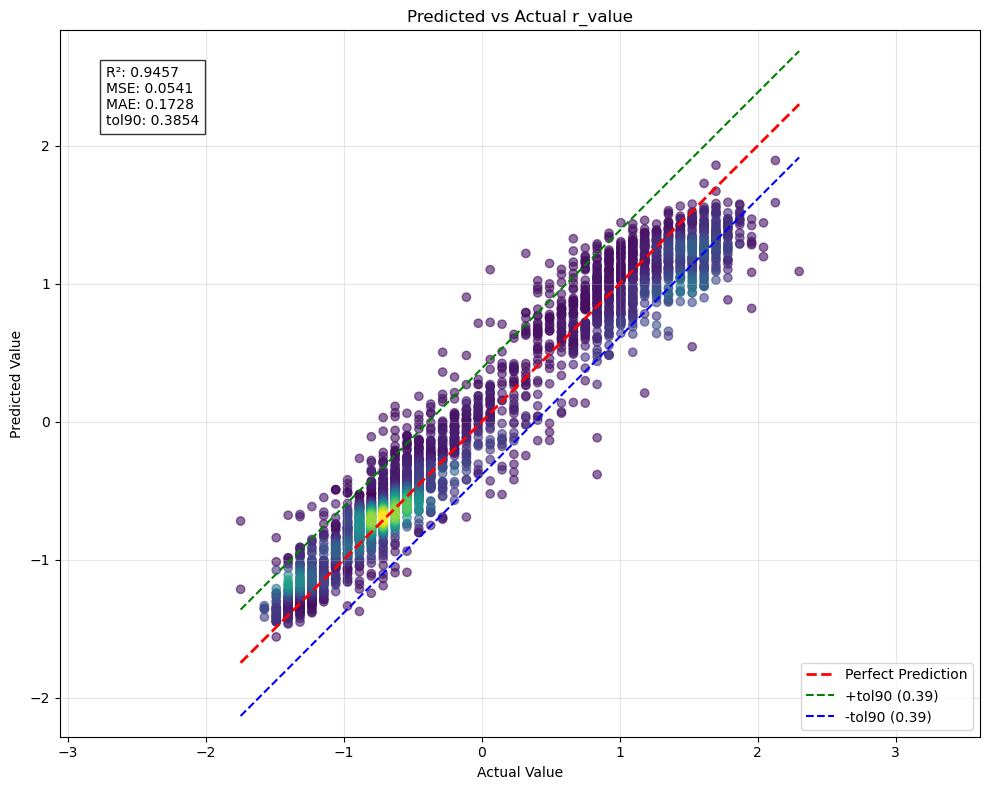

{'R2': 0.9456652564855738,
 'MSE': 0.05406167073397783,
 'MAE': 0.1728283987435345,
 'tol90': 0.38544235694395845}

In [95]:
plot_predicted_vs_actual(best_mlp[0], test_scaled_df, features_dict=features_dict, model_type='pytorch_mlp')

In [1]:
mecomep_test_bmlp = {'R2': 0.9456652564855738,
 'MSE': 0.05406167073397783,
 'MAE': 0.1728283987435345,
 'tol90': 0.38544235694395845}

mecomep_test_ridge = {'R2': 0.9269405565127695,
 'MSE': 0.07269226506545733,
 'MAE': 0.2072006624539791,
 'tol90': 0.4362270586898588}

mecomep_test_svr = {'R2': 0.9377914255433754,
 'MSE': 0.06189592977854506,
 'MAE': 0.17742747012557605,
 'tol90': 0.40054608835422856}

mecomep_test_knn = {'R2': 0.9332973716407997,
 'MSE': 0.06636739769441521,
 'MAE': 0.18483594473670553,
 'tol90': 0.4161785900761575}

mecomep_test_gpr = {'R2': 0.940498904530411,
 'MSE': 0.0592020579011998,
 'MAE': 0.1762977421082072,
 'tol90': 0.38628006102153506}

mecomep_test_ann = {'R2': 0.9483853070752407,
 'MSE': 0.05135529043571991,
 'MAE': 0.16493635648601848,
 'tol90': 0.3673562140252494}

mecomep_test_xgb = {'R2': 0.9555866919694271,
 'MSE': 0.04419009789414144,
 'MAE': 0.155763582711918,
 'tol90': 0.34122445909398547}

mecomep_test_rfr = {'R2': 0.9575904491557501,
 'MSE': 0.042196411088404086,
 'MAE': 0.1494467211582525,
 'tol90': 0.34050708765634463}

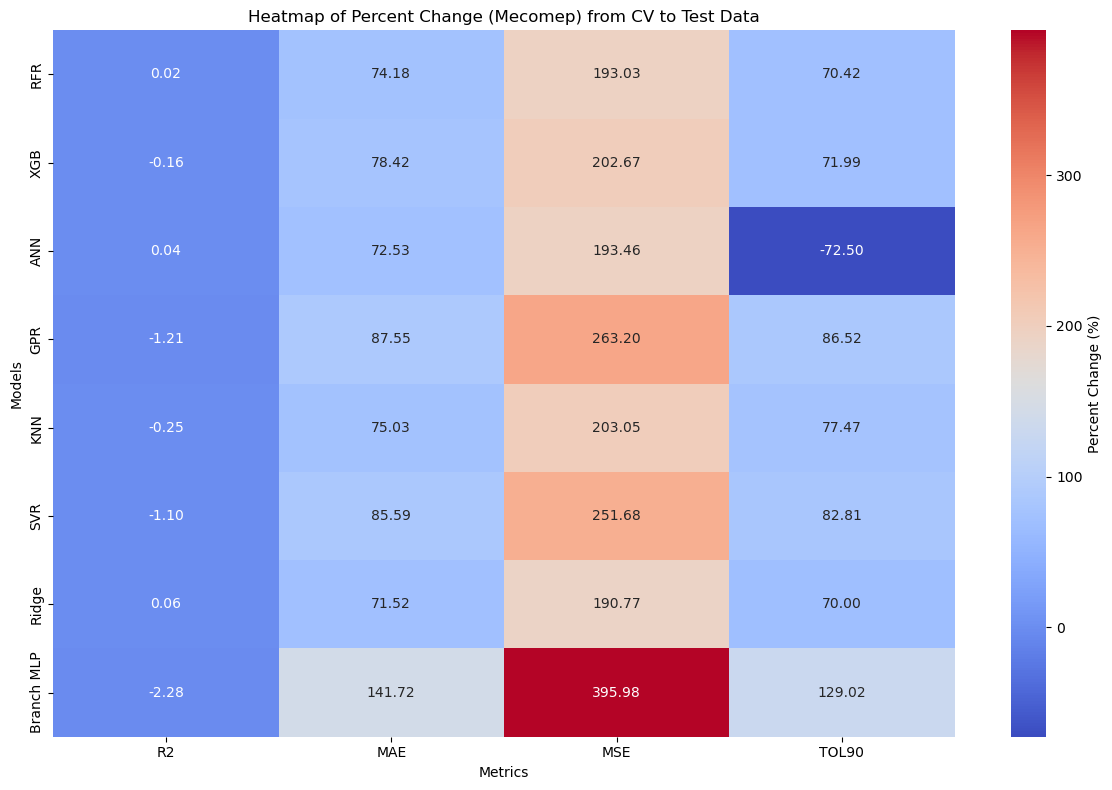

In [3]:
import seaborn as sns

models = ['RFR', 'XGB', 'ANN', 'GPR', 'KNN', 'SVR', 'Ridge', 'Branch MLP']
mecomep_test_data = pd.DataFrame({

    'R2': [0.9575904491557501, 0.9555866919694271, 0.9483853070752407, 0.940498904530411, 

           0.9332973716407997, 0.9377914255433754, 0.9269405565127695, 0.9456652564855738],

    'MAE': [0.1494467211582525, 0.155763582711918, 0.16493635648601848, 0.1762977421082072,

            0.18483594473670553, 0.17742747012557605, 0.2072006624539791, 0.1728283987435345],

    'MSE': [0.042196411088404086, 0.04419009789414144, 0.05135529043571991, 0.0592020579011998,

            0.06636739769441521, 0.06189592977854506, 0.07269226506545733, 0.05406167073397783],

    'TOL90': [0.34050708765634463, 0.34122445909398547, 0.3673562140252494, 0.38628006102153506,

              0.4161785900761575, 0.40054608835422856, 0.4362270586898588, 0.38544235694395845]

}, index=models)

mecomep_cv_data = pd.DataFrame({
    'R2': [0.9574, 0.9571, 0.9480, 0.9520, 0.9356, 0.9482, 0.9264, 0.9677],
    'MAE': [0.0858, 0.0873, 0.0956, 0.0940, 0.1056, 0.0956, 0.1208, 0.0715],
    'MSE': [0.0144, 0.0146, 0.0175, 0.0163, 0.0219, 0.0176, 0.0250, 0.0109],
    'TOL90': [0.1998, 0.1984, 1.3360, 0.2071, 0.2345, 0.2191, 0.2566, 0.1683]
}, index=models)

# Calculate percentage change for Mecomep
mecomep_percent_change = (mecomep_test_data - mecomep_cv_data) / mecomep_cv_data * 100

# Plot heatmap for Mecomep
plt.figure(figsize=(12, 8))
sns.heatmap(mecomep_percent_change, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Percent Change (%)'})
plt.title("Heatmap of Percent Change (Mecomep) from CV to Test Data")
plt.ylabel("Models")
plt.xlabel("Metrics")
plt.tight_layout()
plt.show()


In [ ]:
best_params_grid = {'batch_size': 32,
 'cross_branch_dropout': 0,
 'dropout_rate': 0.2,
 'final_layer_dropout': [0, 0],
 'final_layer_units': [128, 64],
 'hidden_units': 64,
 'learning_rate': 0.001,
 'normalization': 'layer'}

best_mlp_enhanced = train_model_enhanced(train_scaled_df, features_dict, num_epochs, best_params_grid)
plot_predicted_vs_actual(best_mlp_enhanced[0], test_scaled_df, features_dict=features_dict, model_type='pytorch_mlp')

In [12]:
def analyze_feature_importance(model, X, feature_names=None, max_samples=1000):
    """
    Compute SHAP values for different model types using appropriate explainers:
    - TreeExplainer for RandomForest and XGBoost
    - LinearExplainer for Ridge regression
    
    Parameters:
    model: trained model (RandomForestRegressor, XGBRegressor, or Ridge)
    X: feature matrix (numpy array or pandas DataFrame)
    feature_names: list of feature names (optional)
    max_samples: maximum number of samples to use for analysis
    
    Returns:
    dict: Sorted dictionary of feature importance values
    """
    print(f"Starting SHAP analysis for dataset of shape: {X.shape}")
    
    # Get feature names
    if feature_names is None and isinstance(X, pd.DataFrame):
        feature_names = list(X.columns)
    
    # Convert to numpy if needed
    if isinstance(X, pd.DataFrame):
        X = X.astype('float32').values
    else:
        X = np.array(X, dtype='float32')
    
    # Sample data if needed
    if len(X) > max_samples:
        print(f"Limiting to {max_samples} samples for faster computation")
        indices = np.random.RandomState(42).choice(len(X), max_samples, replace=False)
        X = X[indices]
    
    try:
        with tqdm(total=3, desc="Computing SHAP values") as pbar:
            # Choose appropriate explainer based on model type
            if isinstance(model, (RandomForestRegressor, XGBRegressor)):
                pbar.set_description("Initializing TreeExplainer")
                explainer = shap.TreeExplainer(model)
                pbar.update(1)
                
                pbar.set_description("Computing SHAP values")
                shap_values = explainer.shap_values(X)
                pbar.update(1)
                
                # Handle case where shap_values is a list (happens with some tree models)
                if isinstance(shap_values, list):
                    shap_values = shap_values[0]
                    
            elif isinstance(model, RidgeCV):
                # For Ridge regression, we use LinearExplainer
                pbar.set_description("Initializing LinearExplainer")
                explainer = shap.LinearExplainer(model, X)
                pbar.update(1)
                
                pbar.set_description("Computing SHAP values")
                shap_values = explainer.shap_values(X)
                pbar.update(1)
                
            else:
                raise ValueError("Unsupported model type. Please use RandomForestRegressor, XGBRegressor, or Ridge")
            
            # Get mean absolute SHAP values
            pbar.set_description("Computing feature importance")
            feature_importance = np.abs(shap_values).mean(axis=0)
            
            # Create and sort importance dictionary
            importance_dict = dict(zip(feature_names, feature_importance))
            top_features = dict(sorted(importance_dict.items(),
                                     key=lambda x: x[1],
                                     reverse=True))
            pbar.update(1)
            
        return top_features
        
    except Exception as e:
        print(f"Error during SHAP analysis: {str(e)}")
        return None

In [13]:
top_features_rf = analyze_feature_importance(
    model=model_info['model'],
    X=test_scaled_df.drop(['r_value'], axis=1),
    max_samples=1000
)

Starting SHAP analysis for dataset of shape: (3087, 44)
Limiting to 1000 samples for faster computation


Computing feature importance: 100%|██████████| 3/3 [05:42<00:00, 114.27s/it]


In [14]:
top_features_xgb = analyze_feature_importance(
    model=trained_models_xgb['model'],
    X=test_scaled_df.drop(['r_value'], axis=1),
    max_samples=1000
)

Starting SHAP analysis for dataset of shape: (3087, 44)
Limiting to 1000 samples for faster computation


Computing feature importance: 100%|██████████| 3/3 [00:00<00:00, 32.29it/s]


In [17]:
top_features_ridge = analyze_feature_importance(
    model=trained_models_ridge['model'],
    X=test_scaled_df.drop(['r_value'], axis=1),
    max_samples=1000
)

Starting SHAP analysis for dataset of shape: (3087, 44)
Limiting to 1000 samples for faster computation


Computing feature importance: 100%|██████████| 3/3 [00:00<00:00, 755.69it/s]


In [24]:
def plot_shap_comparisons(model_shap_values, model_names):
    """
    Plots absolute SHAP values and cumulative sums for multiple models.

    Parameters:
    - model_shap_values: List of dictionaries where each dictionary represents a model 
                         and contains features as keys and SHAP values as values.
    - model_names: List of model names (e.g., ['Model 1', 'Model 2', 'Model 3']).
    """
    # Combine and sort features for consistency across models
    all_features = sorted(set().union(*[set(shap.keys()) for shap in model_shap_values]))

    # Create arrays for SHAP values for each model (fill missing features with 0)
    model_values = [
        np.array([shap.get(f, 0) for f in all_features]) for shap in model_shap_values
    ]

    # Calculate cumulative sums for each model
    model_cumsums = [np.cumsum(values) for values in model_values]

    # Plot absolute SHAP values
    plt.figure(figsize=(14, 6))
    x_indices = np.arange(len(all_features))
    bar_width = 0.8 / len(model_shap_values)  # Divide space among models

    for i, (values, model_name) in enumerate(zip(model_values, model_names)):
        plt.bar(
            x_indices + i * bar_width - (bar_width * (len(model_shap_values) - 1) / 2),
            values,
            bar_width,
            label=model_name,
        )

    plt.xticks(x_indices, all_features, rotation=90)
    plt.ylabel("|SHAP Value|")
    plt.xlabel("Features")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot cumulative sums
    plt.figure(figsize=(14, 6))
    for cumsum, model_name in zip(model_cumsums, model_names):
        plt.plot(all_features, cumsum, marker="o", label=model_name)

    plt.xticks(rotation=90)
    plt.title("Cumulative Sum of SHAP Values")
    plt.ylabel("Cumulative SHAP Value")
    plt.xlabel("Features")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


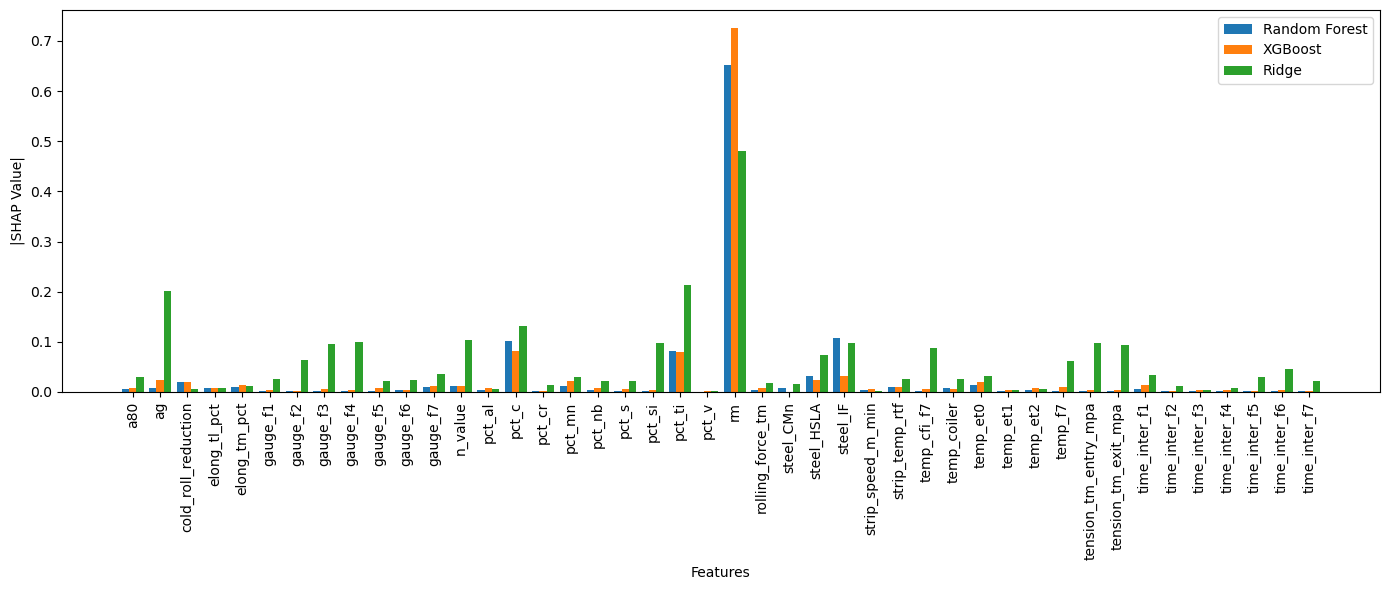

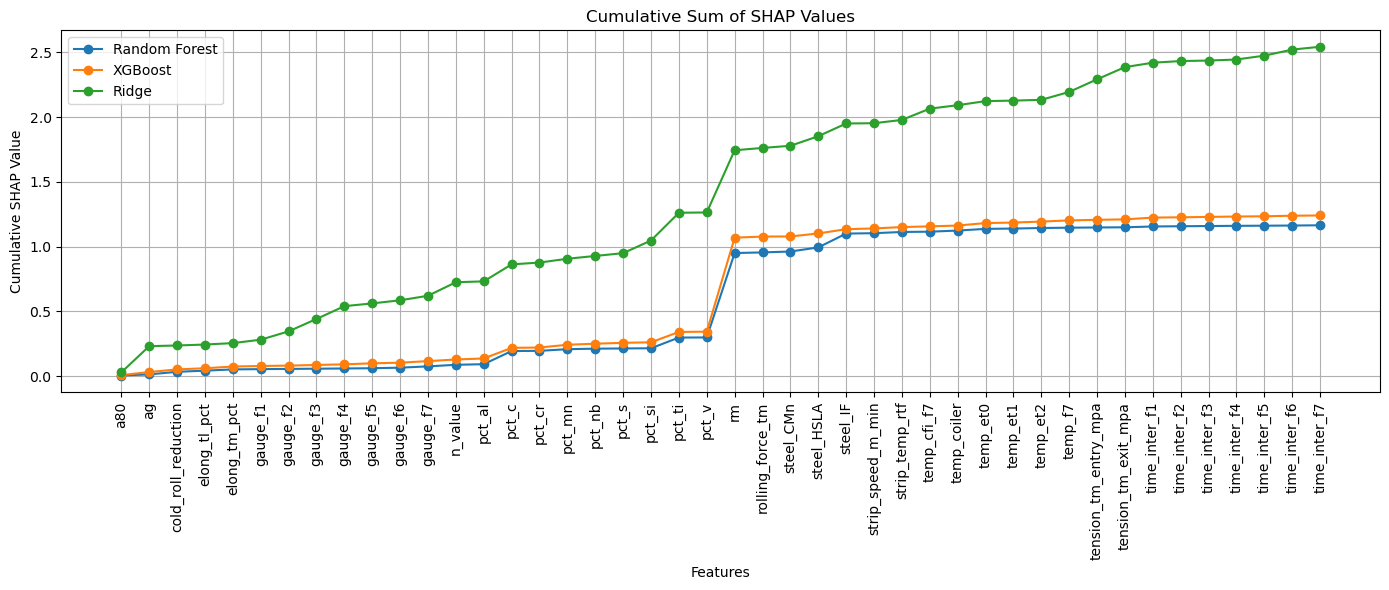

In [25]:
model_names = ['Random Forest', 'XGBoost', 'Ridge']

plot_shap_comparisons(
    model_shap_values=[top_features_rf, top_features_xgb, top_features_ridge],
    model_names=model_names
)

In [ ]:
top_features_gpr = analyze_feature_importance(
    model=trained_models_gpr['model'],
    X=test_scaled_df.drop(['r_value'], axis=1),
    max_samples=1000,
    top_n=5
)

In [ ]:
def analyze_nn_feature_importance(model, feature_dict, train_scaled_df, max_samples=1000, top_n=5):
    """
    Compute SHAP values for the multi-branch neural network model
    """
    print("Starting SHAP analysis for neural network")
    
    # Put model in eval mode
    model.eval()
    
    # Create a wrapper function for the model prediction
    def model_predict(X):
        # Split X into the different branches based on feature dimensions
        current_idx = 0
        branch_data = {}
        
        for category in ['chemical', 'time', 'process', 'model']:
            features = [f for f in feature_dict[category] if f in train_scaled_df.columns]
            if features:
                end_idx = current_idx + len(features)
                # Ensure data is float32
                branch_values = X[:, current_idx:end_idx].astype(np.float32)
                branch_data[category] = torch.FloatTensor(branch_values)
                current_idx = end_idx
            else:
                branch_data[category] = torch.zeros((X.shape[0], 0), dtype=torch.float32)
        
        # Make prediction
        with torch.no_grad():
            predictions = model(
                branch_data['chemical'],
                branch_data['time'],
                branch_data['process'],
                branch_data['model']
            )
        return predictions.numpy()

    # Prepare feature data
    feature_data = []
    feature_names = []
    
    # Combine features from all branches with explicit type conversion
    for category in ['chemical', 'time', 'process', 'model']:
        features = [f for f in feature_dict[category] if f in train_scaled_df.columns]
        if features:
            # Convert to numeric and handle any non-numeric values
            category_data = train_scaled_df[features].apply(pd.to_numeric, errors='coerce').fillna(0)
            feature_data.append(category_data.values.astype(np.float32))
            feature_names.extend(features)
    
    # Concatenate all features
    X = np.hstack(feature_data).astype(np.float32)
    
    print(f"Combined feature data shape: {X.shape}, dtype: {X.dtype}")
    
    # Sample data if needed
    if len(X) > max_samples:
        print(f"Limiting to {max_samples} samples for faster computation")
        indices = np.random.RandomState(42).choice(len(X), max_samples, replace=False)
        X = X[indices]
    
    try:
        # Create background data for KernelExplainer
        background = shap.sample(X, 100).astype(np.float32)  # Sample 100 background points
        print("Background data shape:", background.shape)
        
        # Create explainer
        explainer = shap.KernelExplainer(model_predict, background)
        
        # Calculate SHAP values
        shap_values = explainer.shap_values(X)
        
        # If shap_values is a list (multiple outputs), take the first element
        if isinstance(shap_values, list):
            shap_values = shap_values[0]
        
        # Get mean absolute SHAP values
        feature_importance = np.abs(shap_values).mean(axis=0)
        
        # Create and sort importance dictionary
        importance_dict = dict(zip(feature_names, feature_importance))
        top_features = dict(sorted(importance_dict.items(), 
                                 key=lambda x: x[1], 
                                 reverse=True)[:top_n])
        
        # Print top features and their importance scores
        print("\nTop feature importance scores:")
        for feat, score in top_features.items():
            print(f"{feat}: {score:.4f}")
        
        return top_features, shap_values, X, feature_names
        
    except Exception as e:
        print(f"Error during SHAP analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

def plot_shap_summary(shap_values, X, feature_names):
    """
    Create SHAP summary plot
    """
    try:
        shap.summary_plot(shap_values, X, feature_names=feature_names)
    except Exception as e:
        print(f"Error creating SHAP summary plot: {str(e)}")

In [ ]:
top_features, shap_values, X, feature_names = analyze_nn_feature_importance(
    best_mlp[0], 
    features_dict,
    test_scaled_df,
    max_samples=1000,
    top_n=10
)